In [1]:
%env CUDA_VISIBLE_DEVICES=6

env: CUDA_VISIBLE_DEVICES=6


In [2]:
#!pip install cupy pynvrtc git+https://github.com/seliverstov/pytorch-qrnn

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import torchtext.data as data
from datetime import datetime
import spacy
from spacy.symbols import ORTH, LEMMA, POS, TAG
import re
import matplotlib.pyplot as plt
from bleu import moses_multi_bleu
from torchqrnn import QRNN
%matplotlib inline

/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [4]:
torch.manual_seed(42)

In [5]:
NLP = spacy.load('en')

def tokenizer(s):
    s = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(s))
    s = re.sub(r"[ ]+", " ", s)
    s = re.sub(r"\!+", "!", s)
    s = re.sub(r"\,+", ",", s)
    s = re.sub(r"\?+", "?", s)
    if (s.startswith("'") and s.endswith("'")) or (s.startswith('"') and s.endswith('"')):
        s = s[1:-1]
    MAX_CHARS = 20_000
    if (len(s) > MAX_CHARS):
        s = s[:MAX_CHARS]
        
    special_case = [{ORTH: '<nl>'}]
    NLP.tokenizer.add_special_case('<nl>', special_case)
    return [x.text for x in NLP.tokenizer(s) if x.text != " "]

/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [6]:
TEXT = torchtext.data.Field(eos_token='<eos>', 
                            init_token='<sos>', 
                            tokenize=tokenizer, 
                            lower=True)
LABEL = torchtext.data.Field(sequential=False, unk_token=None)

In [7]:
class Multi30KEminem(torchtext.data.Dataset):

    urls = ['http://files.deeppavlov.ai/datasets/multi30k_eminem.2l.zip']
    name = 'multi30k_eminem_2l'
    dirname = ''

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    def __init__(self, path, text_field, label_field, **kwargs):
       
        fields = [('text', text_field), ('label', label_field)]
        examples = []

        with open(path) as f:
            for line in f.readlines():
                line = line.strip()
                label = line[-1]
                text = line[:-2]
                examples.append(data.Example.fromlist([text, label], fields))
        
        super().__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='multi30k_eminem.2l.train.txt', 
               validation='multi30k_eminem.2l.test.txt', 
               test='multi30k_eminem.2l.test.txt', **kwargs):
        
        return super().splits(
            root=root, text_field=text_field, label_field=label_field,
            train=train, validation=validation, test=test, **kwargs)

    @classmethod
    def iters(cls, batch_size=32, device=0, root='.data', vectors=None, **kwargs):
        
        TEXT = data.Field()
        LABEL = data.Field(sequential=False)

        train, valid, test = cls.splits(TEXT, LABEL, root=root, **kwargs)

        TEXT.build_vocab(train, vectors=vectors)
        LABEL.build_vocab(train)

        return data.BucketIterator.splits(
            (train, test), batch_size=batch_size, device=device)


In [8]:
Multi30KEminem.download('.')

'./multi30k_eminem_2l/'

In [9]:
train_ds, valid_ds, _ = Multi30KEminem.splits(TEXT, LABEL, '.')
len(train_ds), len(valid_ds)

(36000, 2000)

In [10]:
TEXT.build_vocab(train_ds)
LABEL.build_vocab(train_ds)
len(TEXT.vocab) , len(LABEL.vocab)

(17133, 2)

In [11]:
LABEL.vocab.itos[0], LABEL.vocab.itos[1]

('E', 'M')

In [12]:
batch_size = 128

In [13]:
train_dl = torchtext.data.Iterator(train_ds, batch_size, repeat=False, shuffle=False)
valid_dl = torchtext.data.Iterator(valid_ds, batch_size, repeat=False)
gen_dl = torchtext.data.Iterator(train_ds, 1, repeat=False)

In [14]:
vocab_size = len(TEXT.vocab)

In [15]:
TEXT.vocab.load_vectors('fasttext.en.300d')

In [16]:
def to_onehot(data, n_digits):
    y = torch.zeros(data.shape[0], n_digits).cuda().scatter(1,data[:,None],1)
    return y

In [17]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers, lr = 1e-4, dropout=0.0, vectors = None):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        if vectors is not None:
            self.emb.weight.data.copy_(vectors)
            self.emb.weight.data.requires_grad = False
            
        self.rnn = nn.LSTM(emb_size, hidden_size, n_layers, dropout=dropout, bidirectional = True)
        
        self.optim = self.optim = torch.optim.Adam(self.learnable_parameters(), lr)
        
        
    def forward(self, x, hidden = None):
        x = self.emb(x)
        o, (h, c) = self.rnn(x, hidden)
        
        (_, batch_size, hidden_size) = c.shape # [2*n_layers, batch_size, hidden_size]
        c = c.view(-1, 2, batch_size, hidden_size) # [n_layers, 2, batch_size, hidden_size] 
        c = c[-1] # take only last layer
        c = torch.cat((c[0], c[1]), 1) # concatenate ontput from both directions to single vector
        
        return c
    
    def learnable_parameters(self):
        return [p for p in self.parameters() if p.requires_grad]

In [18]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, prior_size, n_layers, dropout=0.0, lr = 1e-4, vectors = None):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        if vectors is not None:
            self.emb.weight.data.copy_(vectors)
            self.emb.weight.data.requires_grad = False
        
        self.rnn = nn.LSTM(emb_size + prior_size, hidden_size, n_layers, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self.optim = self.optim = torch.optim.Adam(self.learnable_parameters(), lr)
        
    def forward(self, x, z, hidden = None, y = None):
        x = self.emb(x)
        
        (seq_len, batch_size, emb_size) = x.shape
        z = z[None, :, :]
        z = z.repeat(seq_len, 1, 1)
        x = torch.cat((x, z), 2)
        
        if y is not None:
            y = y[None, :, :]
            y = y.repeat(seq_len, 1, 1)
            x = torch.cat([x, y], dim=2)
        
        o, h = self.rnn(x, hidden)
        
        (seq_len, batch_size, hidden_size) = o.shape
        
        x = o.view(-1, hidden_size)
        x = F.log_softmax(self.fc(x), dim=1)
        return x, h
    
    def learnable_parameters(self):
        return [p for p in self.parameters() if p.requires_grad]

In [19]:
class Discriminator(nn.Module):
    def __init__(self, sizes, dropout=False, lr=1e-4, bn=False, activation_fn=nn.Tanh(), last_fn=None, first_fn=None):
        super().__init__()
        
        layers = []
        
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if bn:
                layers.append(nn.BatchNorm1d(sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
        self.optim = torch.optim.Adam(self.parameters(), lr)
        
    def forward(self, x, y=None):
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [20]:
class SeqDiscriminator(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, prior_size, 
                 n_layers, dropout=0.0, lr = 1e-4, vectors = None):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        if vectors is not None:
            self.emb.weight.data.copy_(vectors)
            self.emb.weight.data.requires_grad = False
        
        self.rnn = nn.LSTM(emb_size + prior_size, hidden_size, n_layers, dropout=dropout)
       
        self.head = nn.Linear(hidden_size, 1)
        
        self.optim = self.optim = torch.optim.Adam(self.learnable_parameters(), lr)
        
    def forward(self, x, y, logits = False, hidden=None):
        if not logits:
            x = self.emb(x)
        else:
            x = torch.matmul(x, self.emb.weight)
            x = x.permute(1,0,2)
        
        (seq_len, batch_size, emb_size) = x.shape
        
        if y is not None:
            y = y[None, :, :]
            y = y.repeat(seq_len, 1, 1)
            x = torch.cat([x, y], dim=2)
        
        o, h = self.rnn(x, hidden)

        (seq_len, batch_size, hidden_size) = o.shape
        
        x = o[-1].view(-1, hidden_size)
        x = self.head(x)
        return x
    
    def learnable_parameters(self):
        return [p for p in self.parameters() if p.requires_grad]

In [21]:
def seq_to_str(seq):
    (seq_len, batch_size) = seq.shape
    result = []
    for i in range(batch_size):
        result.append(" ".join([TEXT.vocab.itos[w_idx.item()] for w_idx in seq[:,i].view(-1)]))
    return result

In [22]:
def train_raae(epoch, enc, dec, disc, seq_disc, prior_size, train_dl):
    enc.train()
    dec.train()
    disc.train()
    seq_disc.train()
    
    train_g_loss = 0.0
    train_ae_loss = 0.0
    train_disc_loss = 0.0
    train_seq_disc_loss = 0.0
    
    strs = []
    dec_strs = []
    
    for batch_idx, batch in enumerate(train_dl):
       
        seq = batch.text
        seq = seq[1:]
        
        label = batch.label
        label = to_onehot(label, 2)
       
        (seq_len, batch_size) = seq.shape
        
        batch_zeros = torch.zeros((batch_size, 1)).cuda()
        batch_ones = torch.ones((batch_size, 1)).cuda()
        
        # ======== train ZDisc ========
        
        enc.zero_grad()
        disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).cuda()
        z_label = to_onehot(torch.tensor(np.random.randint(0, 2, (batch_size))).cuda(), 2).cuda()

        latent = enc(seq)
        fake_pred = disc(latent, label)
        true_pred = disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        disc_loss = 0.5*(fake_loss + true_loss)
        
        disc_loss.backward()
        disc.optim.step()
        
        
        # ======== train SeqDisc ========
        
        enc.zero_grad()
        dec.zero_grad()
        seq_disc.zero_grad()
                
        latent = enc(seq)
        
        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        (_, vocab_size) = output.shape
        output = output.view(batch_size, -1, vocab_size)
        
        fake_pred = seq_disc(output, label, logits=True)
        true_pred = seq_disc(seq, label, logits=False)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        seq_disc_loss = 0.5*(fake_loss + true_loss)
        
        seq_disc_loss.backward()
        seq_disc.optim.step()
        
        # ======== train AE ========
        enc.zero_grad()
        dec.zero_grad()
        disc.zero_grad()
        seq_disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        
        latent = enc(seq)
        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        
        
        _, w_idxs = output.topk(1, dim=1)
        dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        ae_loss = F.nll_loss(output, seq.view(-1))        
        
        fake_pred_z = disc(latent, label)
        
        enc_loss = F.binary_cross_entropy_with_logits(fake_pred_z, batch_ones)
        
        (_, vocab_size) = output.shape
        output = output.view(batch_size, -1, vocab_size)
        
        fake_pred_seq = seq_disc(output, label, logits=True)
        
        dec_loss = F.binary_cross_entropy_with_logits(fake_pred_seq, batch_ones)
        
        g_loss = ae_loss + enc_loss + dec_loss
        
        g_loss.backward()
        dec.optim.step()
        enc.optim.step()
        
        # ----------------------------------------------------
        
        train_g_loss += g_loss.item()
        train_ae_loss += ae_loss.item()
        train_disc_loss += disc_loss.item()
        train_seq_disc_loss += seq_disc_loss.item()
        
        
        #_, w_idxs = output.topk(1, dim=1)
        #dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        strs.extend(seq_to_str(seq.detach()))
        dec_strs.extend(seq_to_str(dec_seq.detach()))

    train_g_loss /= len(train_dl)
    train_ae_loss /= len(train_dl)
    train_disc_loss /= len(train_dl)
    train_seq_disc_loss /= len(train_dl)
    
    train_bleu = moses_multi_bleu(np.array(dec_strs), np.array(strs))
    
    print("Epoch {:3} {:5}: BLEU: {:.2f}, AE: {:.5f}, G: {:.5f}, ZD: {:.5f}, SeqD: {:.5f}  at {}".format(
        epoch, 'Train', train_bleu, train_ae_loss, train_g_loss, train_disc_loss, 
        train_seq_disc_loss, datetime.now().strftime("%H:%M:%S")))
    
    return train_ae_loss, train_g_loss, train_disc_loss, train_seq_disc_loss, train_bleu

In [23]:
def validate_raae(epoch, enc, dec, disc, seq_disc, prior_size, valid_dl, name):
    enc.eval()
    dec.eval()
    disc.eval()
    seq_disc.eval()
    
    valid_g_loss = 0.0
    valid_ae_loss = 0.0
    valid_disc_loss = 0.0
    valid_seq_disc_loss = 0.0
    
    strs = []
    dec_strs = []
    
    for batch_idx, batch in enumerate(valid_dl):
            
        seq = batch.text
        seq = seq[1:]
        
        label = batch.label
        label = to_onehot(label, 2)
       
        (seq_len, batch_size) = seq.shape
        
        # ======== valid Disc ========
        
        batch_zeros = torch.zeros((batch_size, 1)).cuda()
        batch_ones = torch.ones((batch_size, 1)).cuda()
        
        z = torch.randn((batch_size, prior_size)).cuda()
        z_label = to_onehot(torch.tensor(np.random.randint(0, 2, (batch_size))).cuda(), 2).cuda()
        
        fake_pred = disc(enc(seq), label)
        true_pred = disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        disc_loss = 0.5*(fake_loss + true_loss)
        
        # ======== valid SeqDisc ========

        latent = enc(seq)

        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        (_, vocab_size) = output.shape
        output = output.view(batch_size, -1, vocab_size)
        
        fake_pred = seq_disc(output, label, logits=True)
        true_pred = seq_disc(seq, label, logits=False)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        seq_disc_loss = 0.5*(fake_loss + true_loss)
        
        
        # ======== valid AE ========
        
        z = torch.randn((batch_size, prior_size))
        
        latent = enc(seq)
        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        _, w_idxs = output.topk(1, dim=1)
        dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        ae_loss = F.nll_loss(output, seq.view(-1))        
        
        fake_pred_z = disc(latent,label)
        
        enc_loss = F.binary_cross_entropy_with_logits(fake_pred_z, batch_ones)
        
        (_, vocab_size) = output.shape
        output = output.view(batch_size, -1, vocab_size)
        
        fake_pred_seq = seq_disc(output, label, logits=True)
        
        dec_loss = F.binary_cross_entropy_with_logits(fake_pred_seq, batch_ones)
        
        g_loss = ae_loss + enc_loss + dec_loss
        
        # ------------------------------------------------------------------
        
        valid_g_loss += g_loss.item()
        valid_ae_loss += ae_loss.item()
        valid_disc_loss += disc_loss.item()
        valid_seq_disc_loss += seq_disc_loss.item()
        
        #_, w_idxs = output.topk(1, dim=1)
        #dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        strs.extend(seq_to_str(seq.detach()))
        dec_strs.extend(seq_to_str(dec_seq.detach()))
        
    valid_g_loss /= len(valid_dl)
    valid_ae_loss /= len(valid_dl)
    valid_disc_loss /= len(valid_dl)
    valid_seq_disc_loss /= len(valid_dl)
    
    valid_bleu = moses_multi_bleu(np.array(dec_strs), np.array(strs))
    
    print("Epoch {:3} {:5}: BLEU: {:.2f}, AE: {:.5f}, G: {:.5f}, ZD: {:.5f}, SeqD: {:.5f}  at {}".format(
        epoch, name, valid_bleu, valid_ae_loss, valid_g_loss, valid_disc_loss, valid_seq_disc_loss, datetime.now().strftime("%H:%M:%S")))
    
    return valid_ae_loss, valid_g_loss, valid_disc_loss, valid_seq_disc_loss, valid_bleu

In [24]:
def decode_z(dec, z, seq_len, label):
    dec.eval()
    
    (batch_size, hidden_size) = z.shape
    
    label = to_onehot(label, 2)
    
    x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
    h = None
        
    dec_seq = None
    
    for i in range(seq_len):
        o, h = dec(x, z, h, label)
        _, w_idxs = o.topk(1)
        x = w_idxs.view(1, -1)
        dec_seq = w_idxs if dec_seq is None else torch.cat((dec_seq, w_idxs), 0)
        if batch_size == 1 and TEXT.vocab.itos[w_idxs.item()] == '<eos>':
            break
        
    return dec_seq

In [25]:
def print_decoded(enc, dec, dl):
    enc.eval()
    dec.eval()
    
    b = next(iter(dl))
    seq = b.text
    seq = seq[1:]
    
    label = b.label
    
    (seq_len, batch_size) = seq.shape
    
    z = enc(seq)
    
    dec_seq = decode_z(dec, z, seq_len, label)

    origin = seq_to_str(seq.detach())[0].replace(" <nl> ", "\n\t")
    decoded = seq_to_str(dec_seq.detach())[0].replace(" <nl> ", "\n\t")

    print("\nOrigin:\n\t{}".format(origin))
    print("\nDecoded: {}\n\t".format(decoded))
    

In [26]:
def print_sample(dec, sample_size, max_seq_len):
    dec.eval()
    
    z = torch.randn(1, sample_size).cuda()
    print("\nRandom sample:")
    
    label_0 = torch.zeros(1).long().cuda()
    dec_seq = decode_z(dec, z, max_seq_len, label_0)
    seq_0 = seq_to_str(dec_seq.detach())[0].replace(" <nl> ", "\n\t")
    print("\nDecoded w. style {}:\n\t{}".format(LABEL.vocab.itos[0], seq_0))
    
    label_1 = (torch.zeros(1) + 1).long().cuda()
    dec_seq = decode_z(dec, z, max_seq_len, label_1)
    seq_1 = seq_to_str(dec_seq.detach())[0].replace(" <nl> ", "\n\t")
    print("\nDecoded w. style {}:\n\t{}\n".format(LABEL.vocab.itos[1], seq_1))

In [27]:
def plot_metrics(metrics, idx = 0, metric_name = 'Loss'):
    plt.figure(figsize=(20,10))
    for model, (trn, val, tst) in metrics.items():
        trn = [metric[idx] for metric in trn]
        val = [metric[idx] for metric in val]
        tst = [metric[idx] for metric in tst]
        if trn:
            plt.plot(trn, label=f'{model} Train')
        if val:
            plt.plot(val, label=f'{model} Valid', marker='v')
        if tst:
            plt.plot(tst, label=f'{model} Test', marker='o')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.show()

In [28]:
hidden_size = 500
prior_size = 2 * hidden_size
label_size = 2

In [29]:
Enc = Encoder(vocab_size, 300, hidden_size, n_layers=3, dropout=0.3, lr=1e-4, 
              vectors=TEXT.vocab.vectors).cuda()

In [30]:
Dec = Decoder(vocab_size, 300, hidden_size, prior_size + label_size, n_layers=3, dropout=0.3, lr=1e-4, 
              vectors=TEXT.vocab.vectors).cuda()

In [31]:
ZDisc = Discriminator([prior_size + label_size, hidden_size, 1], dropout=0.3, lr=1e-4, 
                      activation_fn=nn.LeakyReLU(0.2)).cuda()

In [32]:
SeqDisc = SeqDiscriminator(vocab_size, 300, 100, prior_size = label_size, n_layers=2, 
                           dropout=0.3, lr=1e-4, vectors=TEXT.vocab.vectors).cuda()

In [33]:
Enc

Encoder(
  (emb): Embedding(17133, 300)
  (rnn): LSTM(300, 500, num_layers=3, dropout=0.3, bidirectional=True)
)

In [34]:
Dec

Decoder(
  (emb): Embedding(17133, 300)
  (rnn): LSTM(1302, 500, num_layers=3, dropout=0.3)
  (fc): Linear(in_features=500, out_features=17133, bias=True)
)

In [35]:
ZDisc

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=1002, out_features=500, bias=True)
    (1): Dropout(p=0.3)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [36]:
SeqDisc

SeqDiscriminator(
  (emb): Embedding(17133, 300)
  (rnn): LSTM(302, 100, num_layers=2, dropout=0.3)
  (head): Linear(in_features=100, out_features=1, bias=True)
)

In [37]:
metrics = {'model': ([], [], [])}

========== Start epoch 1 at 19:39:32 ==========
Epoch   1 Train: BLEU: 47.52, AE: 4.35488, G: 6.85385, ZD: 2.11104, SeqD: 0.23753  at 19:44:07
Epoch   1 Valid: BLEU: 48.89, AE: 3.55459, G: 7.61742, ZD: 3.81658, SeqD: 0.01409  at 19:44:14

Origin:
	a young boy on the beach running into the ocean waves . <eos>

Decoded: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
	

Random sample:

Decoded w. style E:
	<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

Decoded w. style M:
	<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

========== Start epoch 2 at 19:44:14 ==========

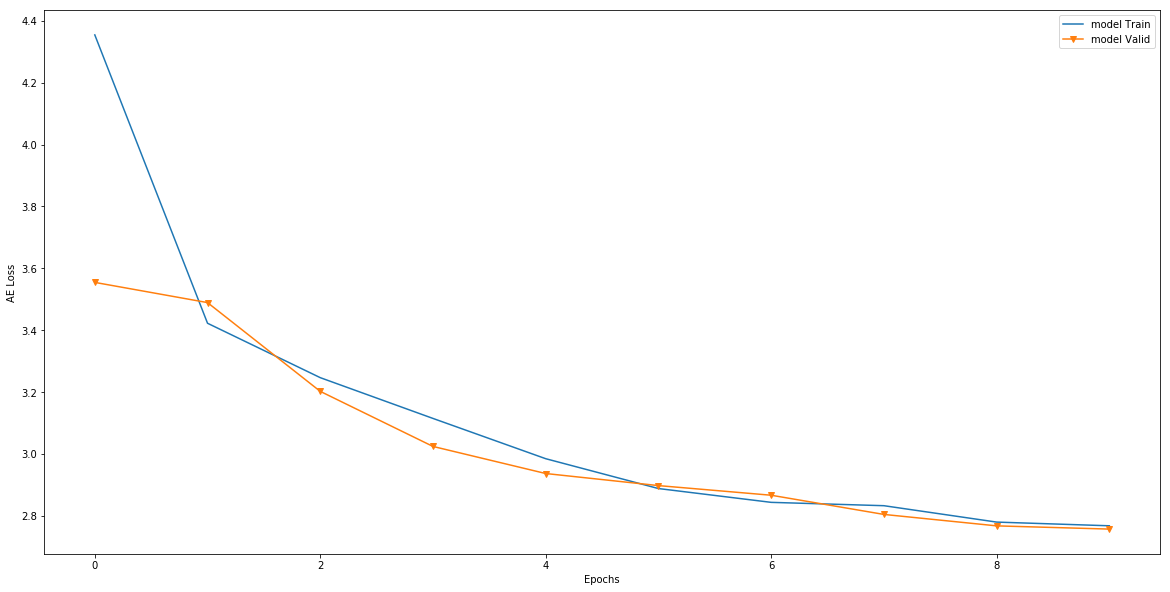

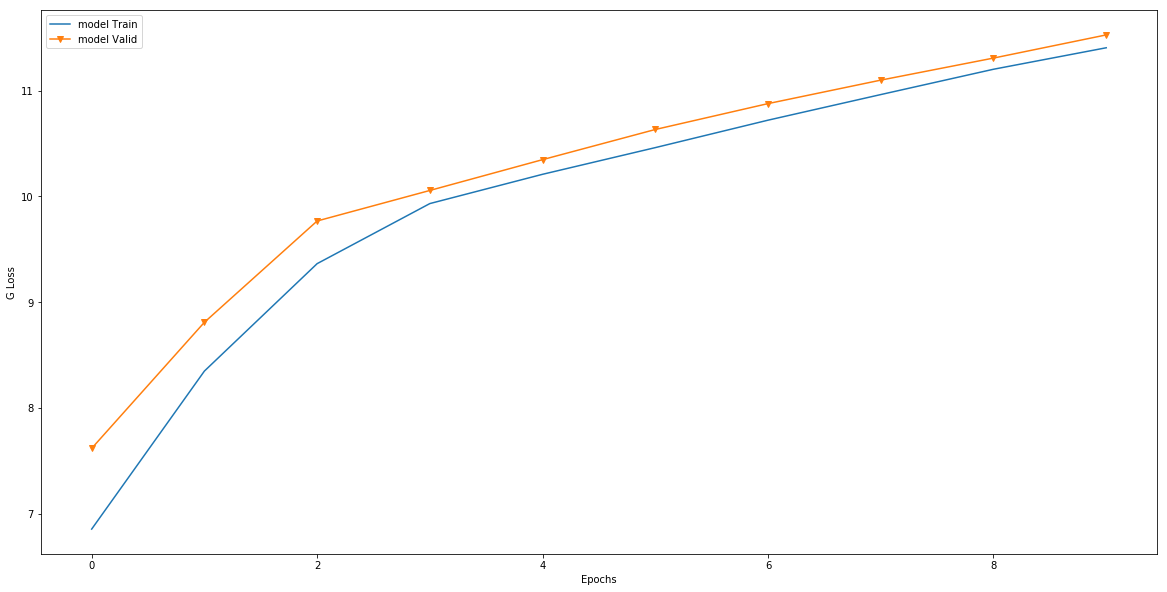

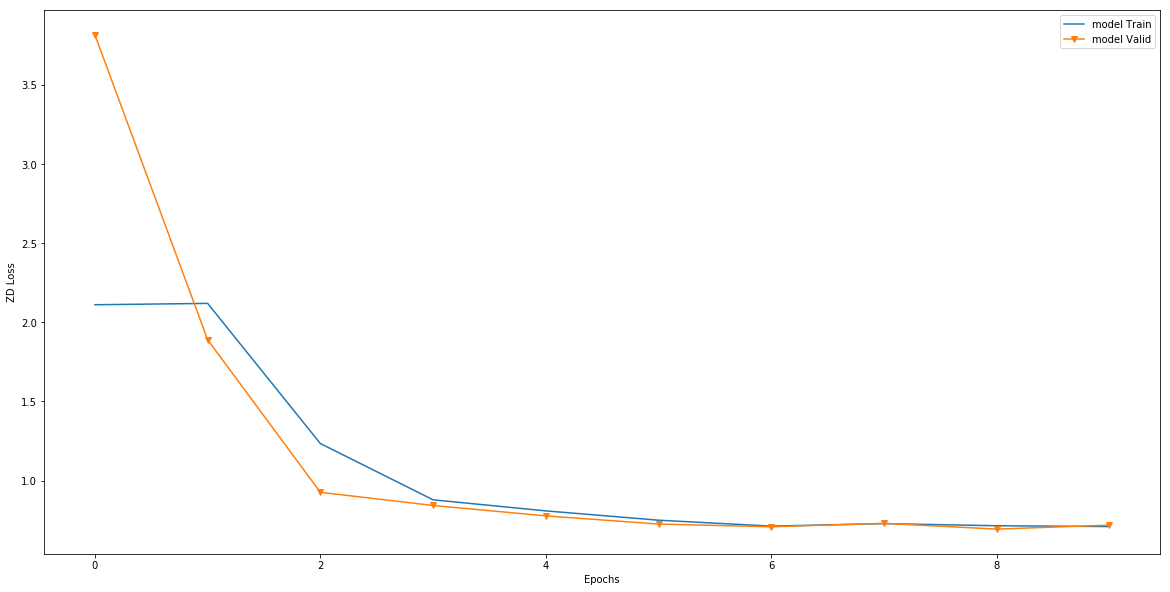

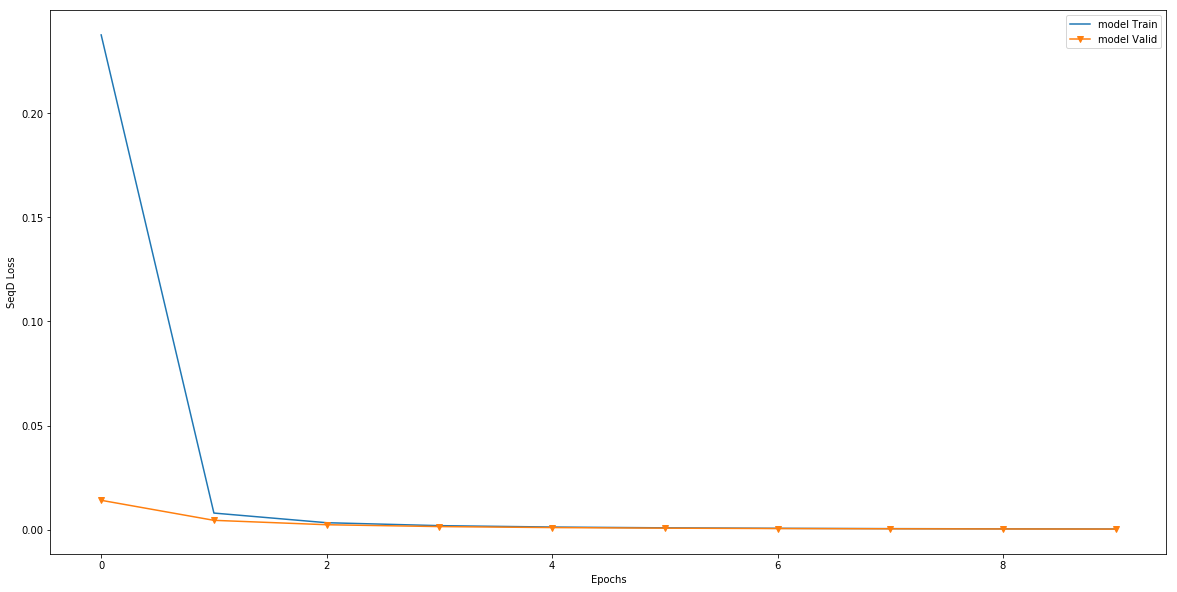

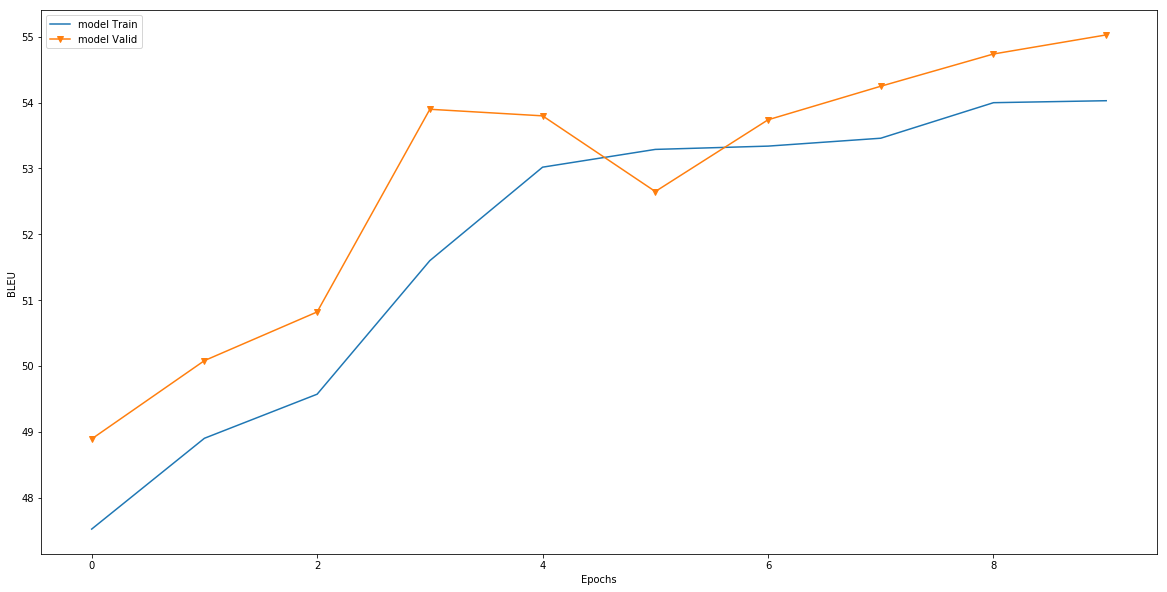

========== Start epoch 11 at 20:24:53 ==========
Epoch  11 Train: BLEU: 54.45, AE: 2.72238, G: 11.59435, ZD: 0.70281, SeqD: 0.00025  at 20:29:14
Epoch  11 Valid: BLEU: 55.32, AE: 2.73354, G: 11.69924, ZD: 0.69559, SeqD: 0.00022  at 20:29:22

Origin:
	keep tapping the glass lightly then start to crescendo
	sneak all the way ' round to the back porch <eos>

Decoded: a man in a a a a a a a a a a a a a a a a a a
	

Random sample:

Decoded w. style E:
	a man in a a a a a a a a a a a . <eos>

Decoded w. style M:
	a man in a a a a a a a a a a . . <eos>

========== Start epoch 12 at 20:29:22 ==========
Epoch  12 Train: BLEU: 54.48, AE: 2.70457, G: 11.77083, ZD: 0.71011, SeqD: 0.00021  at 20:33:43
Epoch  12 Valid: BLEU: 55.07, AE: 2.69258, G: 11.87105, ZD: 0.69675, SeqD: 0.00018  at 20:33:51

Origin:
	now this looks like a job for me
	so everybody , just follow me <eos>

Decoded: a man , , , , ,
	<nl>
	i i i i i i
	

Random sample:

Decoded w. style E:
	a i , , , ,
	<nl>
	<nl> i i i i i you <eo

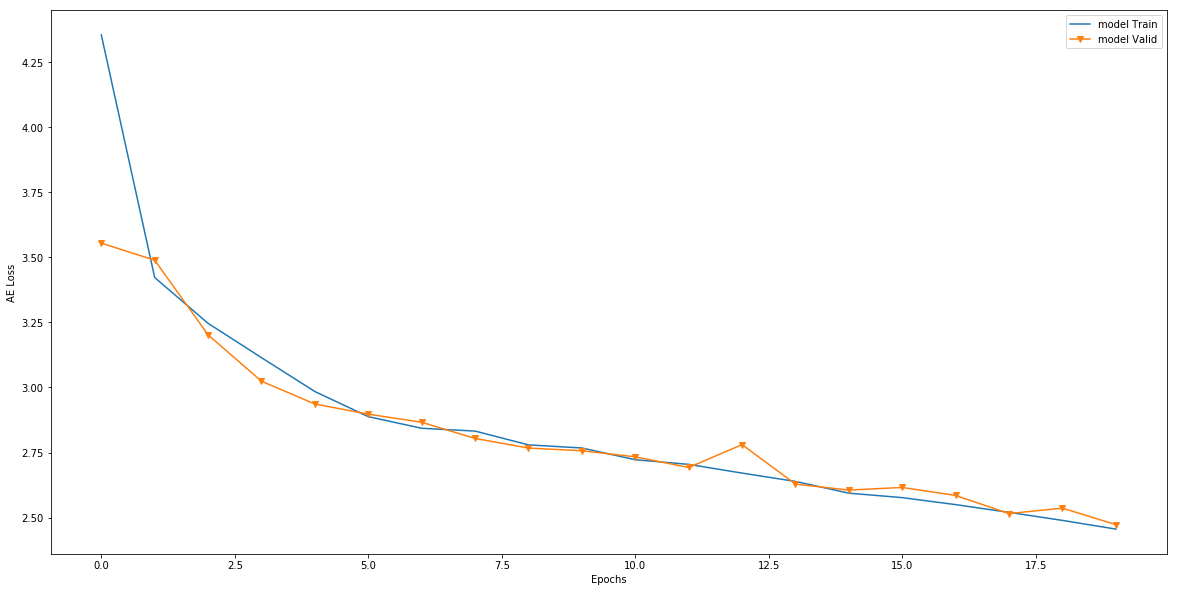

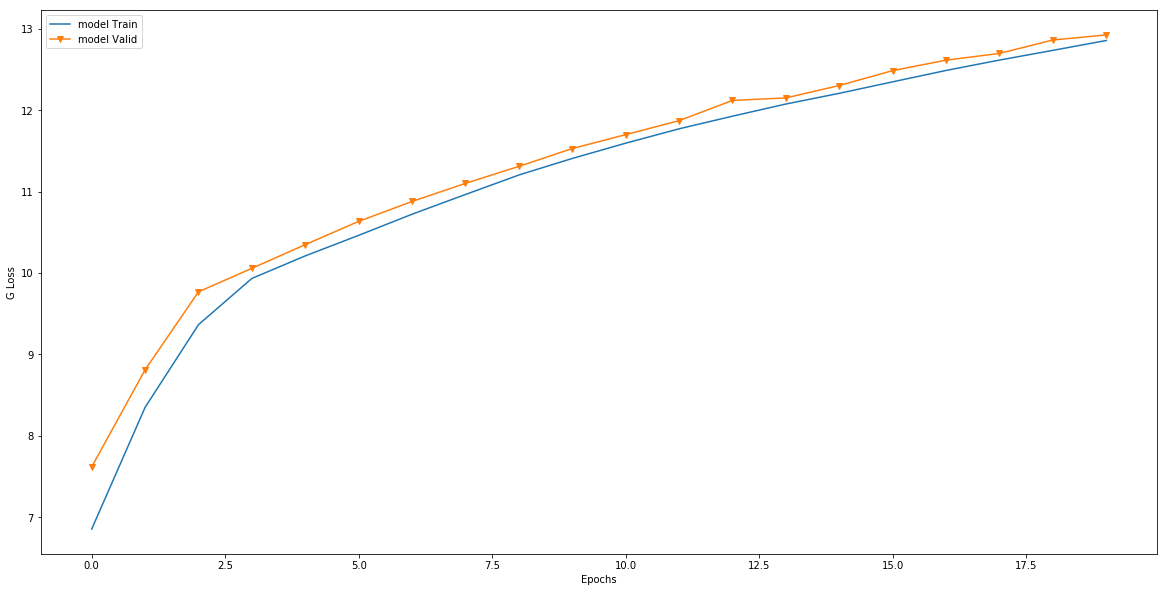

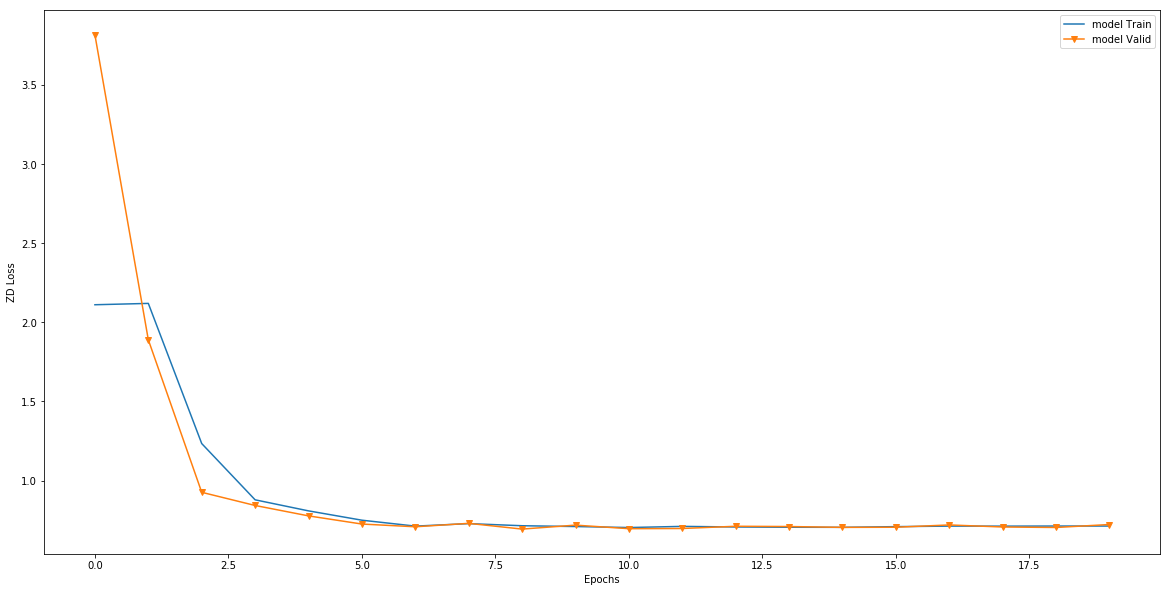

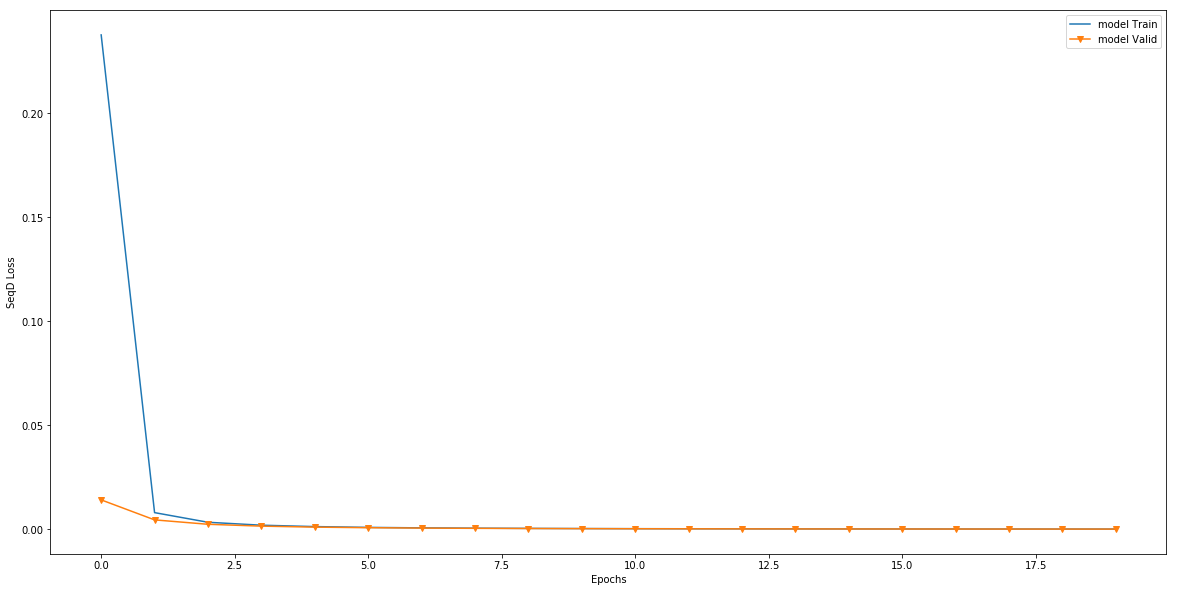

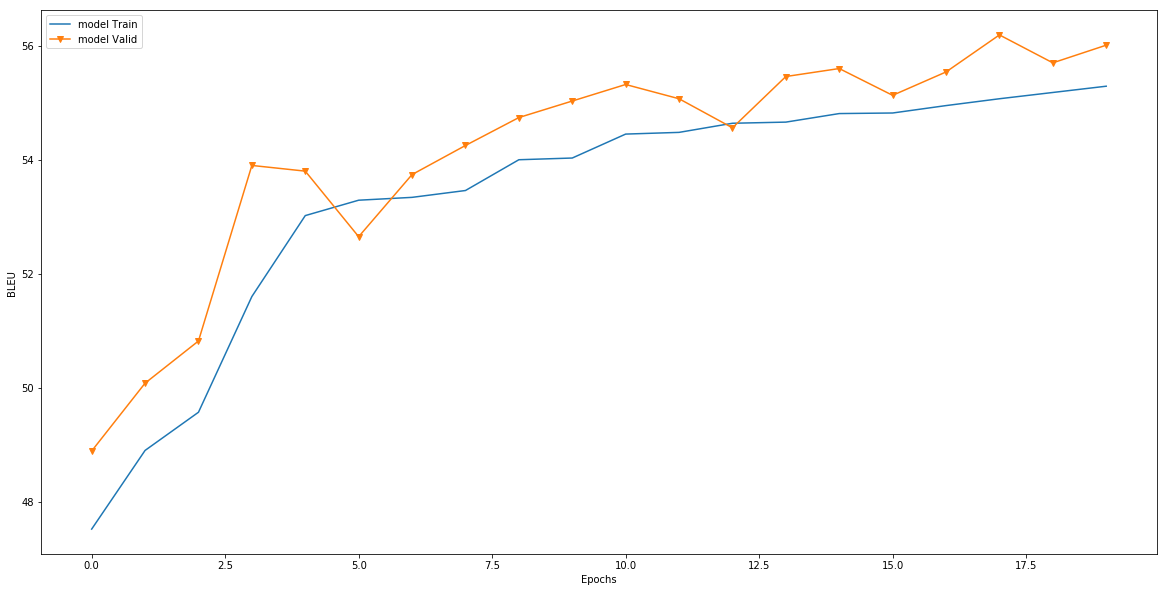

========== Start epoch 21 at 21:09:51 ==========
Epoch  21 Train: BLEU: 55.34, AE: 2.43192, G: 12.97920, ZD: 0.71255, SeqD: 0.00005  at 21:14:14
Epoch  21 Valid: BLEU: 55.07, AE: 2.52525, G: 13.17851, ZD: 0.69909, SeqD: 0.00004  at 21:14:21

Origin:
	i followed the voice that led down a flight of steps
	sneezing at dust and swinging at the spider webs <eos>

Decoded: and the of a of a of a of a of the of the of the of the of the of the
	

Random sample:

Decoded w. style E:
	a man is a of the of the of the . <eos>

Decoded w. style M:
	a man is a of a of a of the . <eos>

========== Start epoch 22 at 21:14:22 ==========
Epoch  22 Train: BLEU: 55.42, AE: 2.40360, G: 13.10281, ZD: 0.71404, SeqD: 0.00004  at 21:18:43
Epoch  22 Valid: BLEU: 55.47, AE: 2.47939, G: 13.27953, ZD: 0.71379, SeqD: 0.00004  at 21:18:51

Origin:
	a young girl in pink is playing with a pink toy on asphalt . <eos>

Decoded: a man in a blue shirt and a shirt and a red of a of
	

Random sample:

Decoded w. style E:
	a

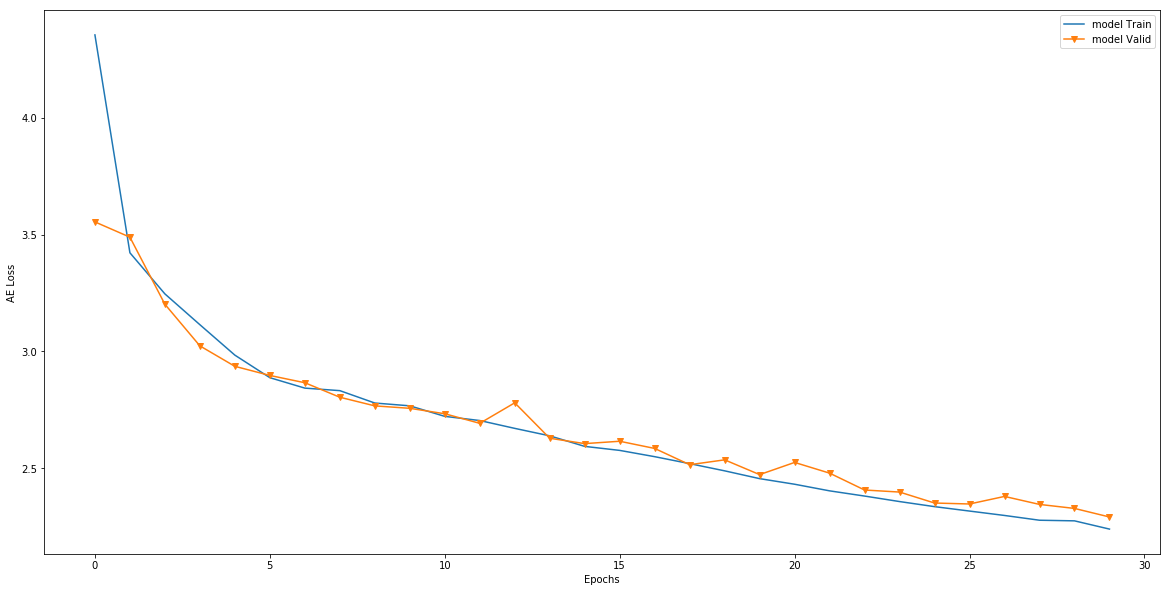

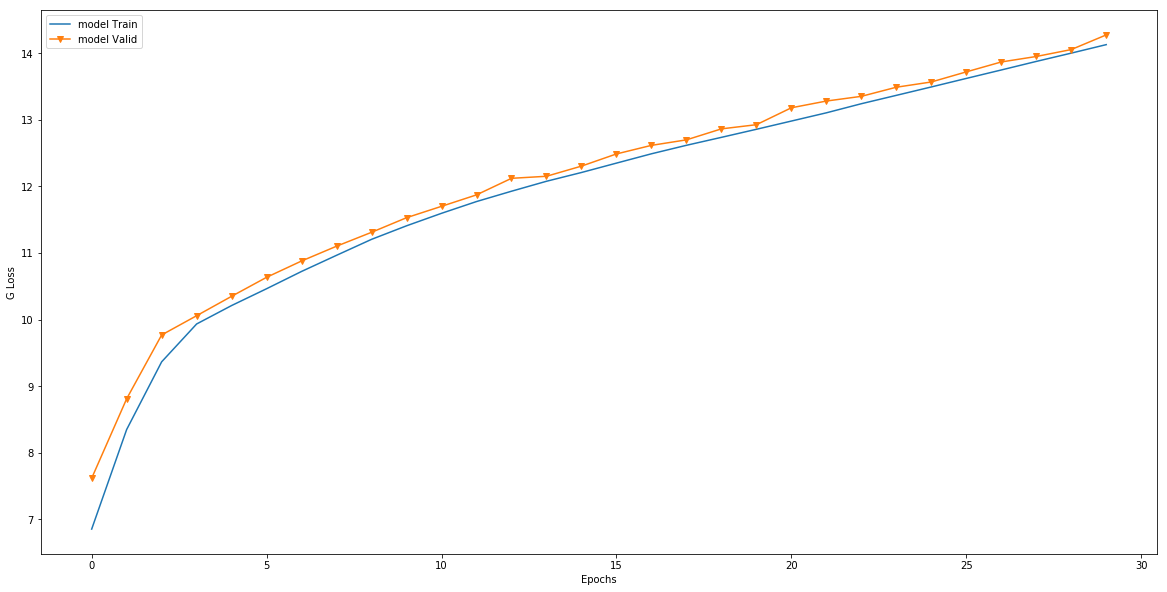

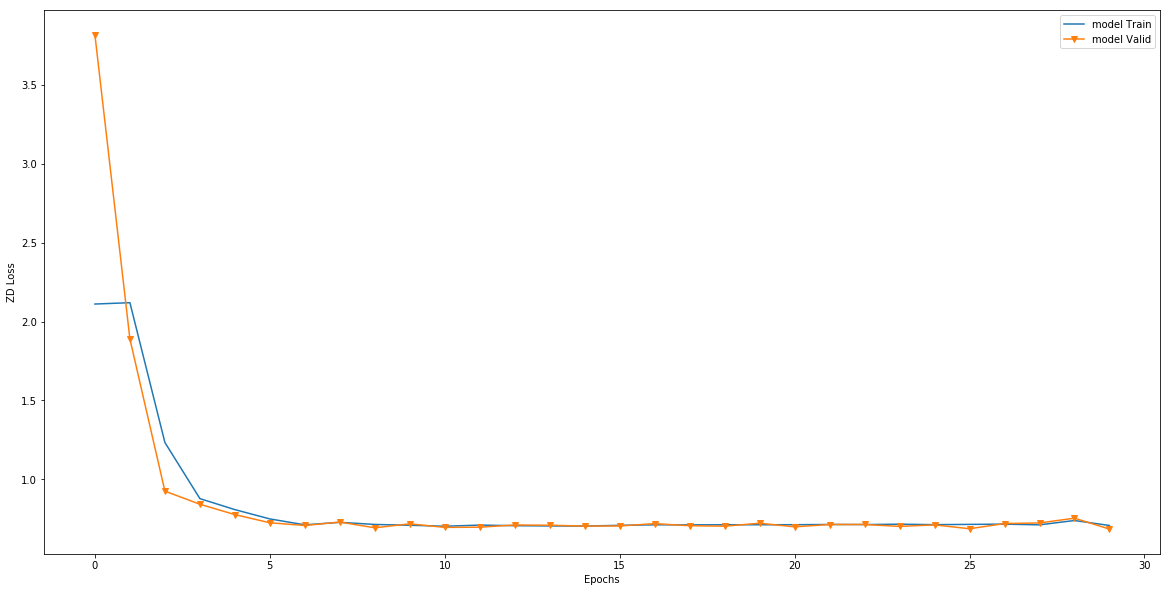

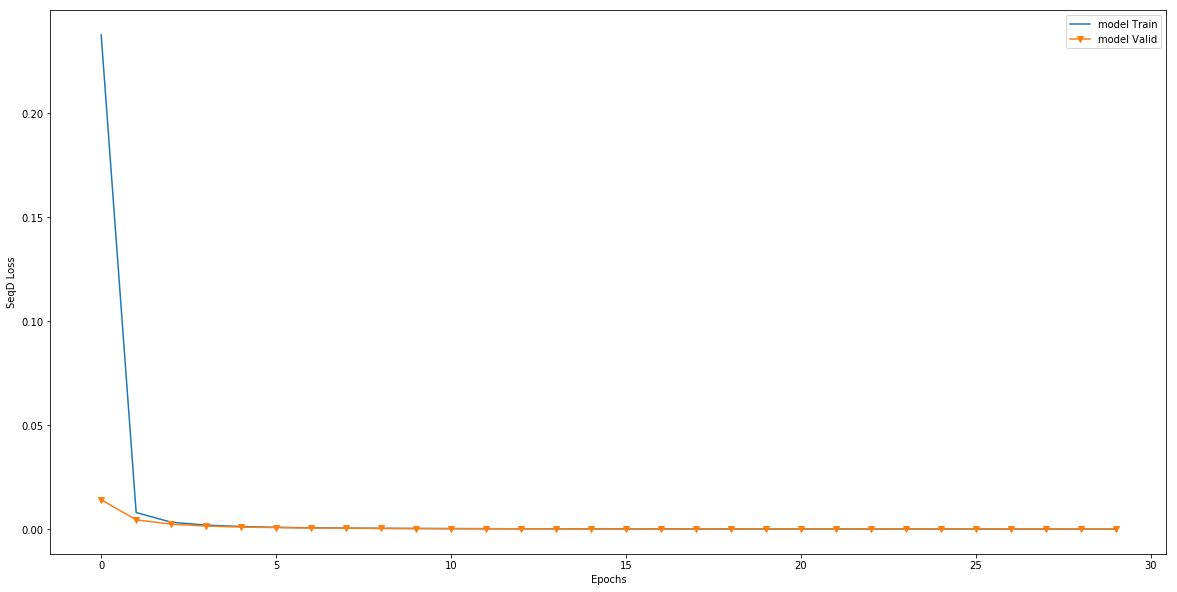

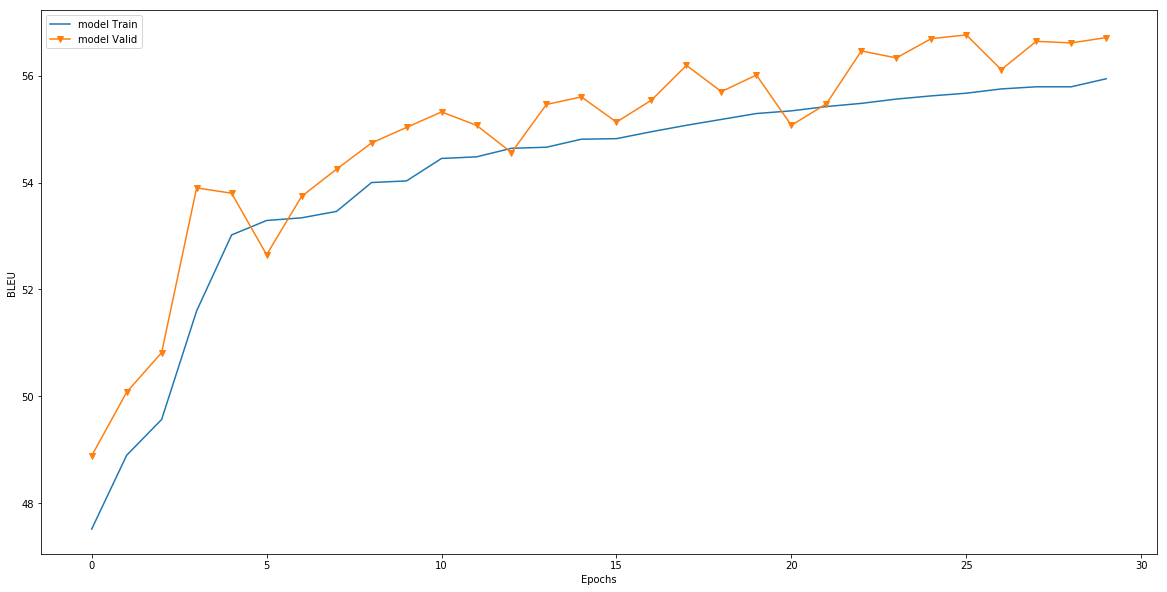

========== Start epoch 31 at 21:54:51 ==========
Epoch  31 Train: BLEU: 55.94, AE: 2.23677, G: 14.25237, ZD: 0.72033, SeqD: 0.00001  at 21:59:12
Epoch  31 Valid: BLEU: 56.53, AE: 2.32295, G: 14.40416, ZD: 0.73213, SeqD: 0.00001  at 21:59:19

Origin:
	a lady wearing red glasses and a floral shirt speaks to passengers in a bus . <eos>

Decoded: a man in a blue shirt and a blue shirt is is on a of a background
	

Random sample:

Decoded w. style E:
	and the ' , the ' , the '
	i 'm a ' , i 'm a ' , i 'm it <eos>

Decoded w. style M:
	a man is a of a of the of that
	i 'm it , i 'm a ' , <eos>

========== Start epoch 32 at 21:59:19 ==========
Epoch  32 Train: BLEU: 56.05, AE: 2.21244, G: 14.37778, ZD: 0.71801, SeqD: 0.00001  at 22:03:40
Epoch  32 Valid: BLEU: 56.41, AE: 2.28028, G: 14.48692, ZD: 0.72973, SeqD: 0.00001  at 22:03:48

Origin:
	while i let 'em fall all the way to the basement yelling stop
	there once was a saying that i used to say <eos>

Decoded: i 'm a ' , i 'm a of the of the

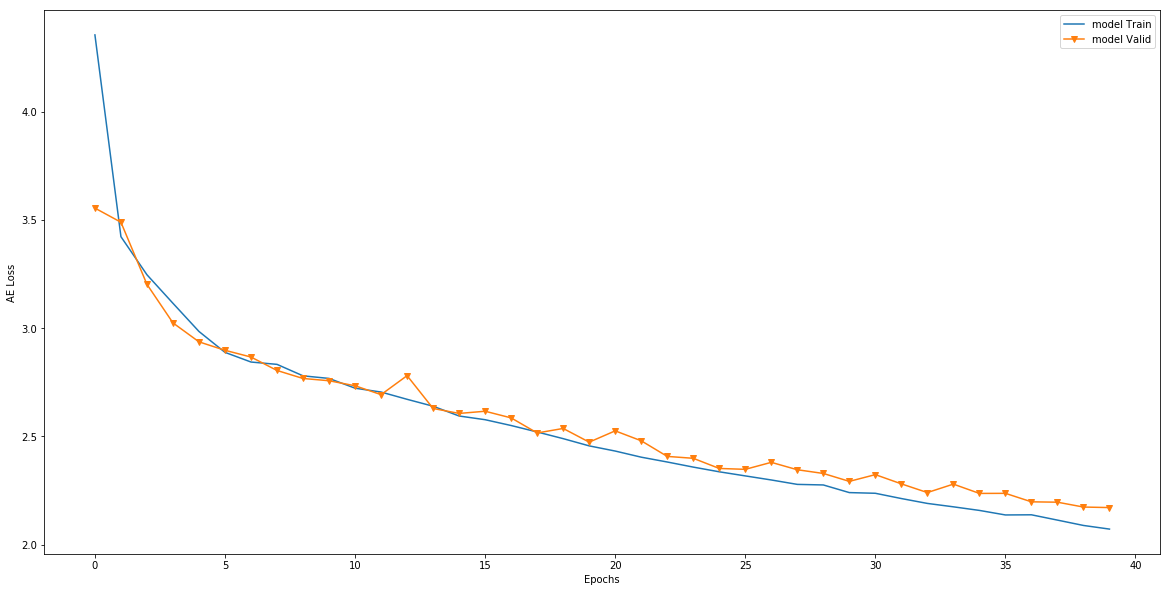

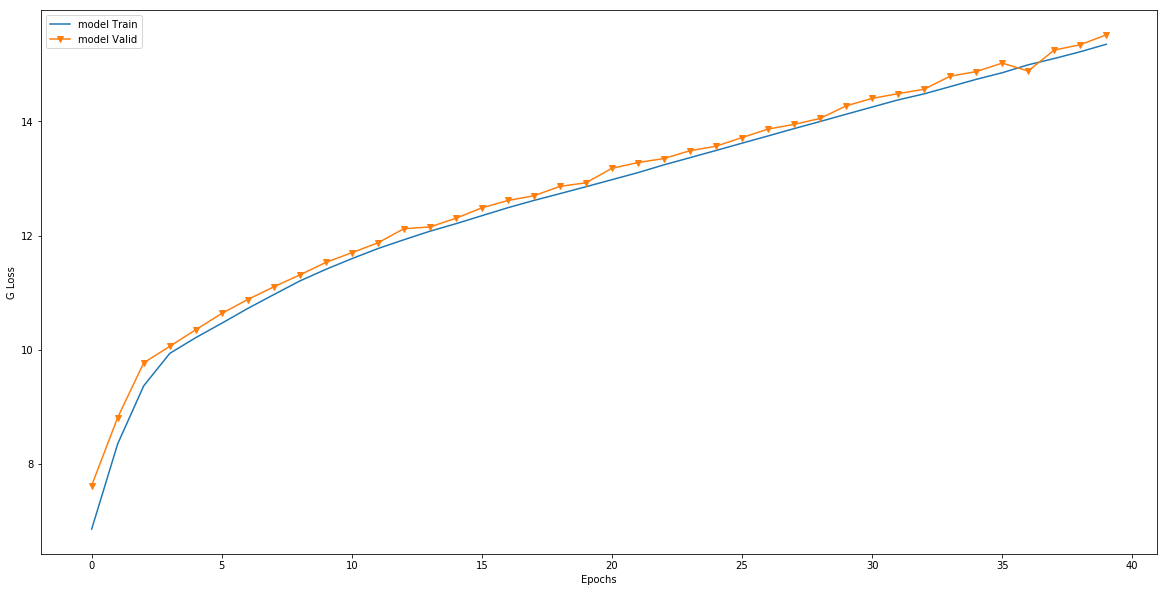

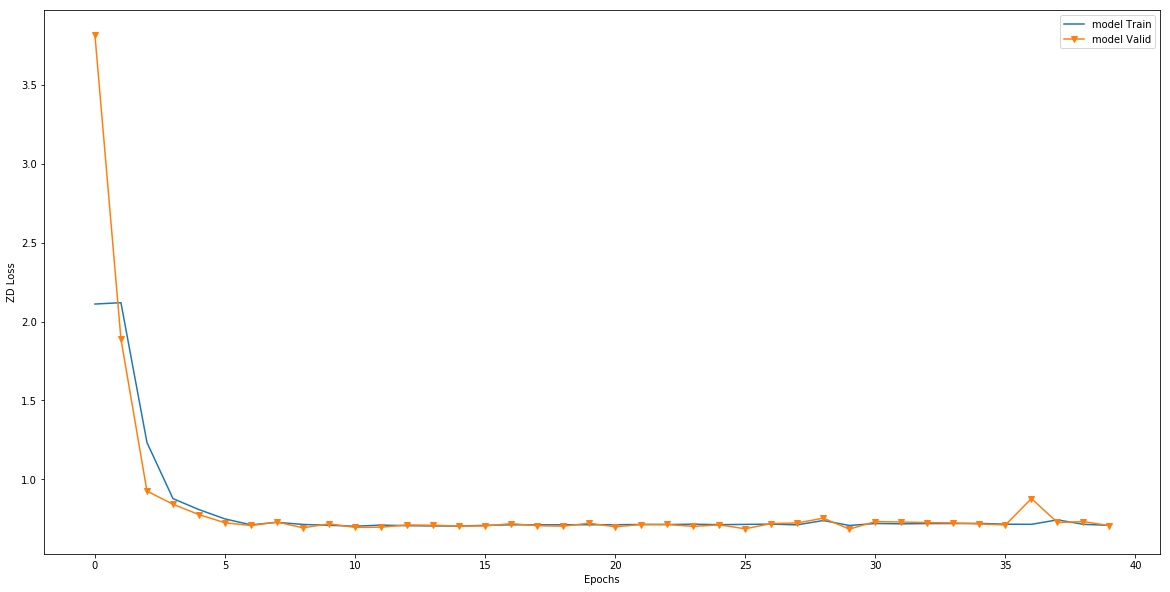

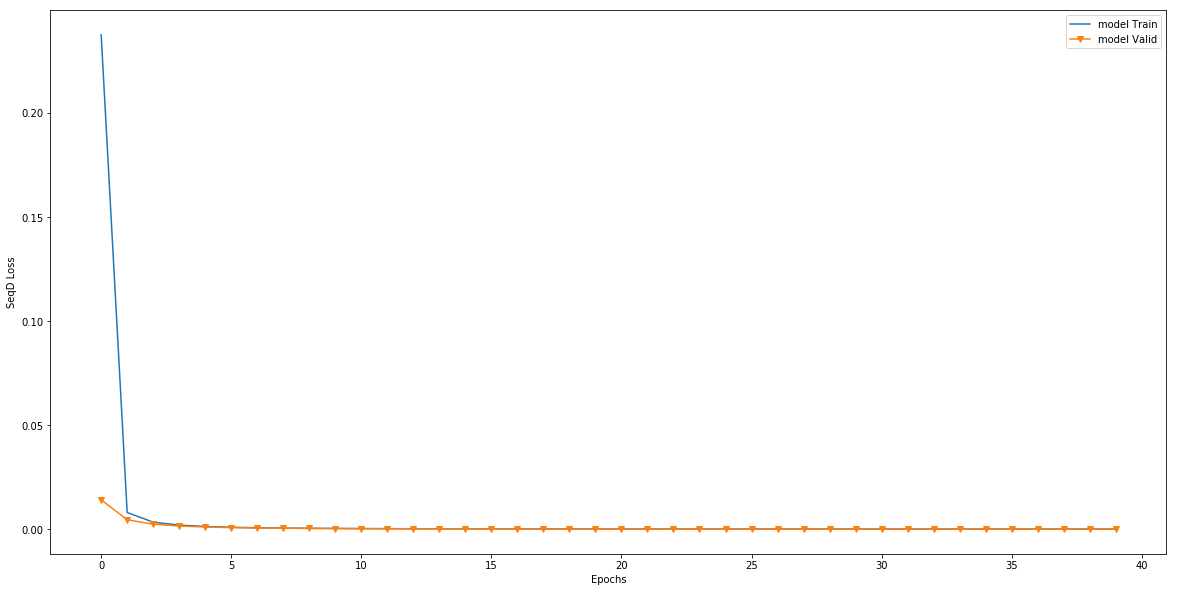

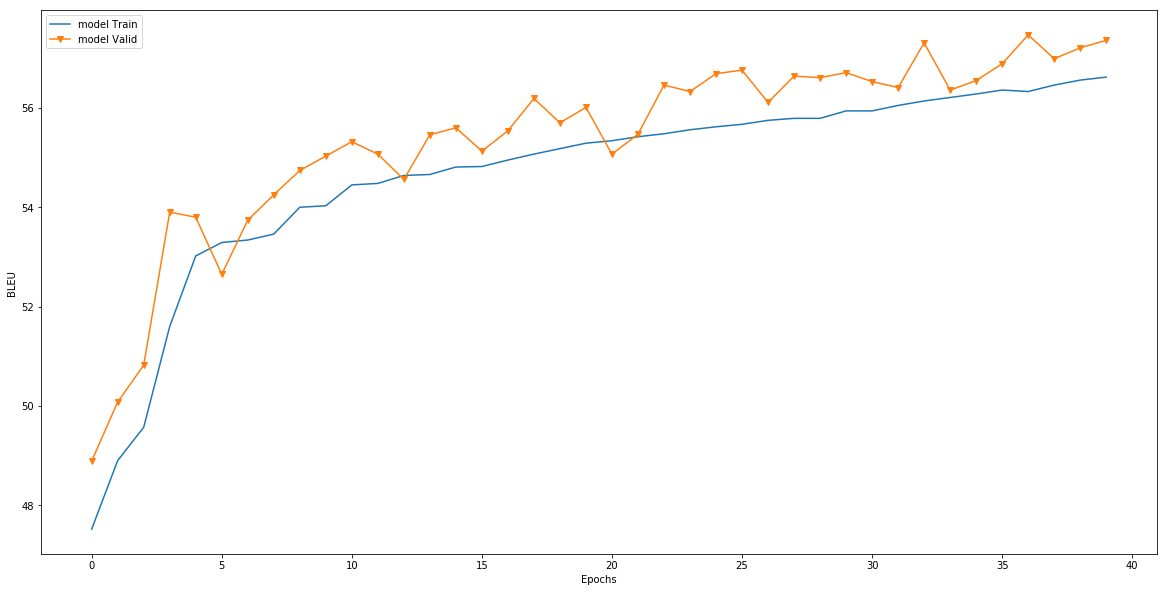

========== Start epoch 41 at 22:39:51 ==========
Epoch  41 Train: BLEU: 56.63, AE: 2.06468, G: 15.47626, ZD: 0.72226, SeqD: 0.00000  at 22:44:13
Epoch  41 Valid: BLEU: 57.18, AE: 2.17077, G: 15.59470, ZD: 0.74662, SeqD: 0.00000  at 22:44:20

Origin:
	i ca n't describe the vibe i get
	when i drive by 6 people and 5 i hit , ah shit <eos>

Decoded: i 'm gon na be , i 'm a fuck
	i 'm a fuck , i 'm a fuckin ' you be
	

Random sample:

Decoded w. style E:
	but 's me , and it 's the
	i 'm a fuck , i 'm a of <eos>

Decoded w. style M:
	and it 's me , my name
	and i 'm a fuck , i 'm a of <eos>

========== Start epoch 42 at 22:44:20 ==========
Epoch  42 Train: BLEU: 56.77, AE: 2.03708, G: 15.58728, ZD: 0.72328, SeqD: 0.00000  at 22:48:42
Epoch  42 Valid: BLEU: 57.15, AE: 2.14855, G: 15.72669, ZD: 0.71586, SeqD: 0.00000  at 22:48:50

Origin:
	cause i will say some inspirational shit in a real way
	but still will have a field day with some of the fucked up shit <eos>

Decoded: but i do n't give a 

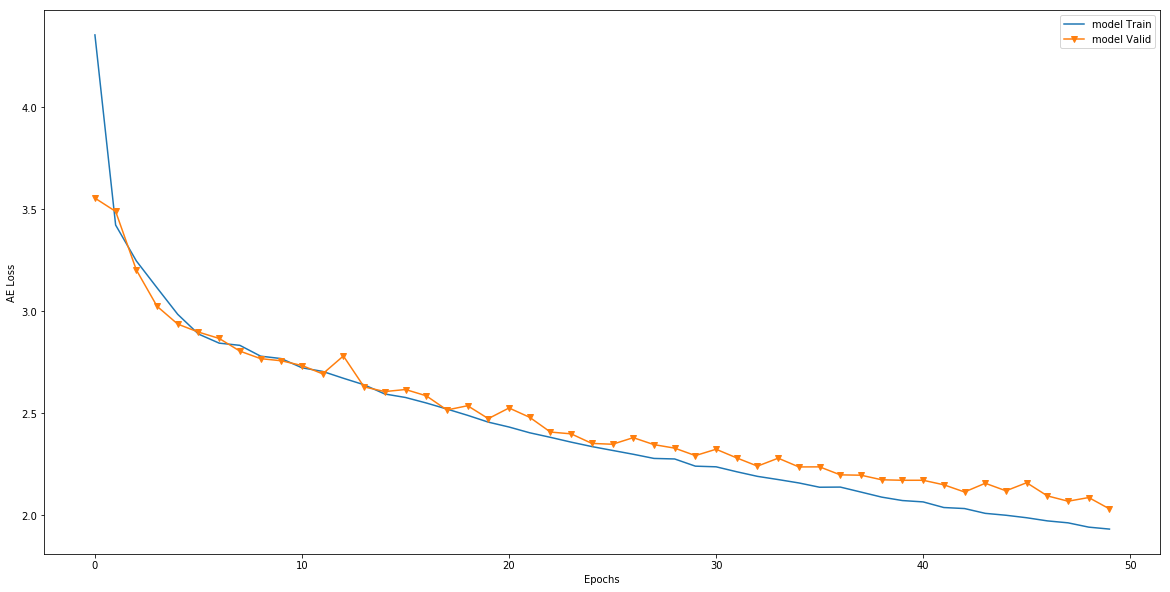

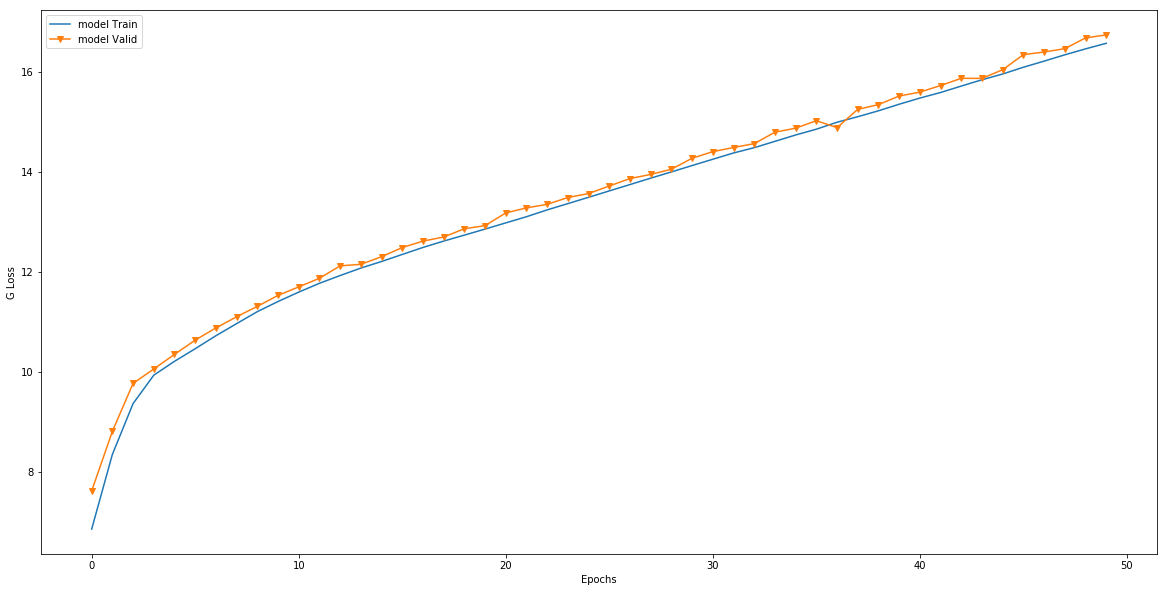

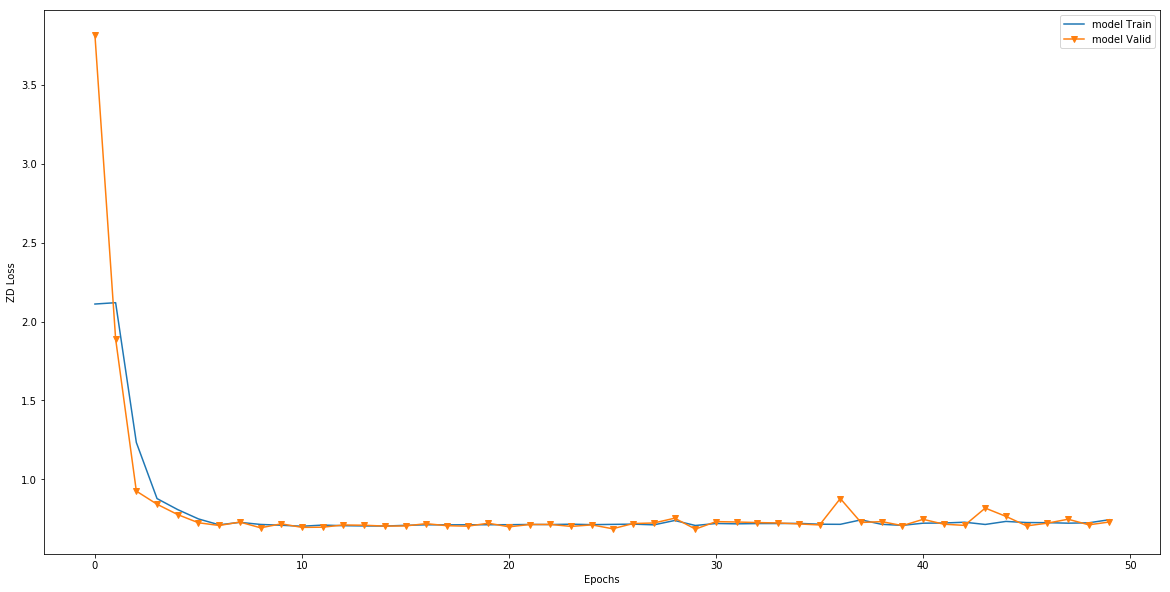

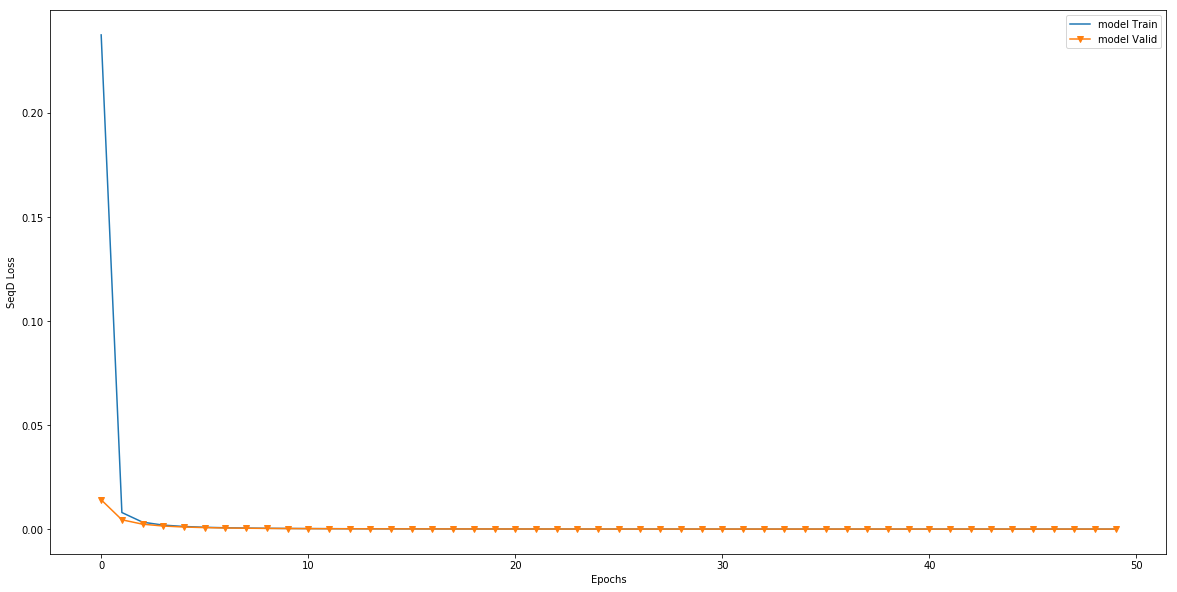

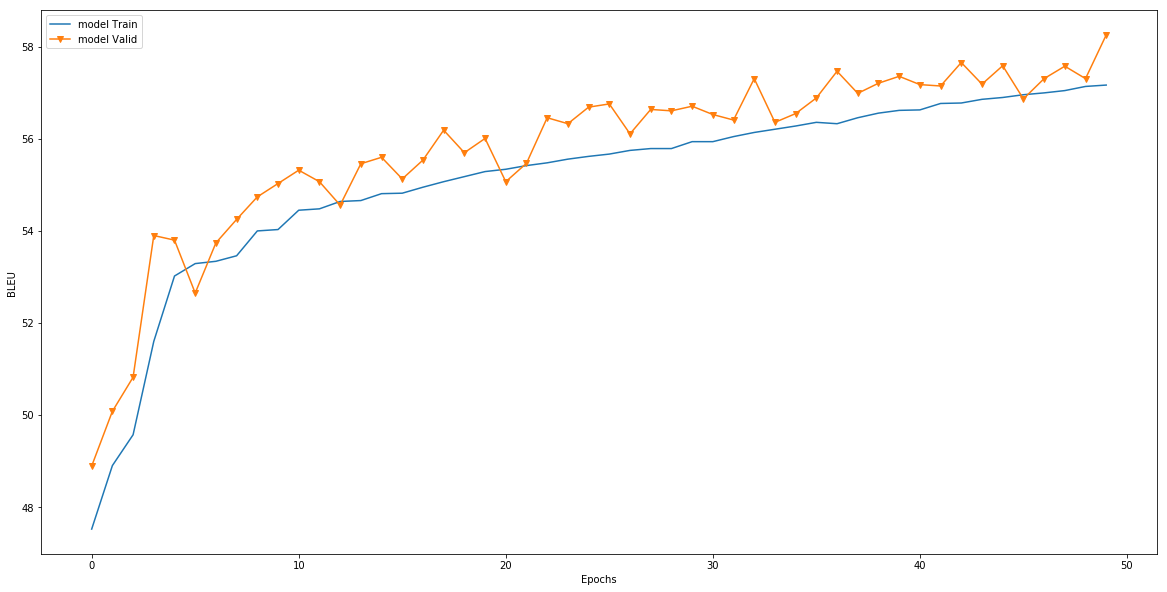

========== Start epoch 51 at 23:24:53 ==========
Epoch  51 Train: BLEU: 57.31, AE: 1.90473, G: 16.70542, ZD: 0.71988, SeqD: 0.00000  at 23:29:16
Epoch  51 Valid: BLEU: 58.02, AE: 2.04000, G: 16.84935, ZD: 0.74498, SeqD: 0.00000  at 23:29:24

Origin:
	so lonely and cold , it 's like something takes over me
	soon as i go home and close the door <eos>

Decoded: and it 's the fuck , and it 's not me
	and it 's not the way , he 's a little
	

Random sample:

Decoded w. style E:
	but it 's not it
	i 'm just a fuck , <eos>

Decoded w. style M:
	and it 's it
	i 'm a fuck , <eos>

========== Start epoch 52 at 23:29:24 ==========
Epoch  52 Train: BLEU: 57.41, AE: 1.88748, G: 16.82345, ZD: 0.72359, SeqD: 0.00000  at 23:33:46
Epoch  52 Valid: BLEU: 57.58, AE: 2.03543, G: 17.03336, ZD: 0.71041, SeqD: 0.00000  at 23:33:54

Origin:
	there are two kids in swimmies playing outside next to some trees . <eos>

Decoded: two men are sitting in a snow while they be a ball . <eos>
	

Random sample:

Decoded 

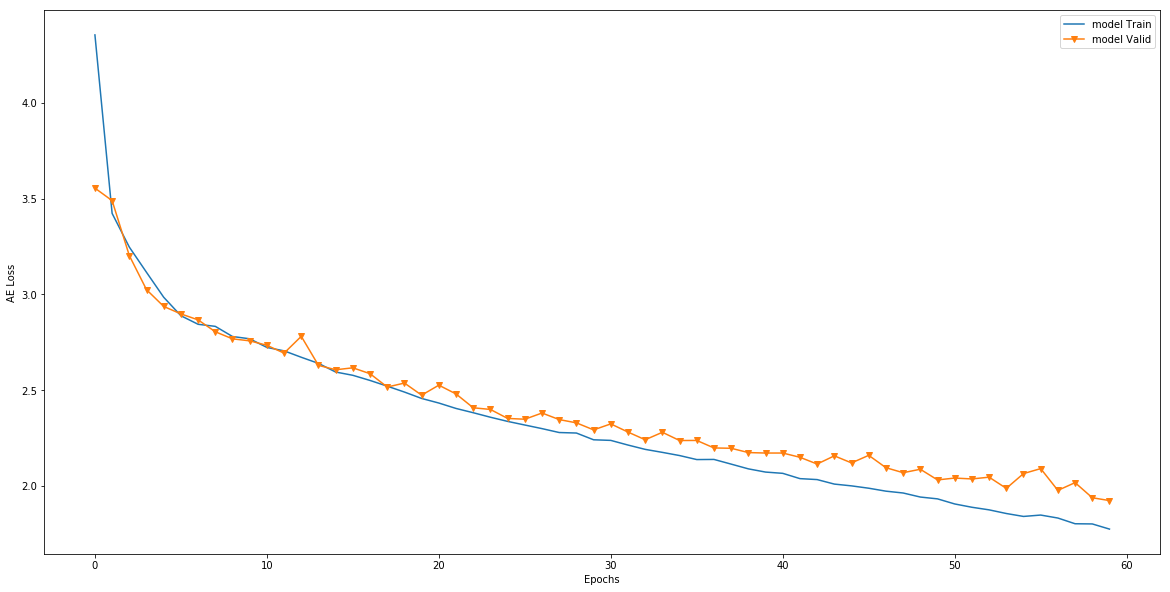

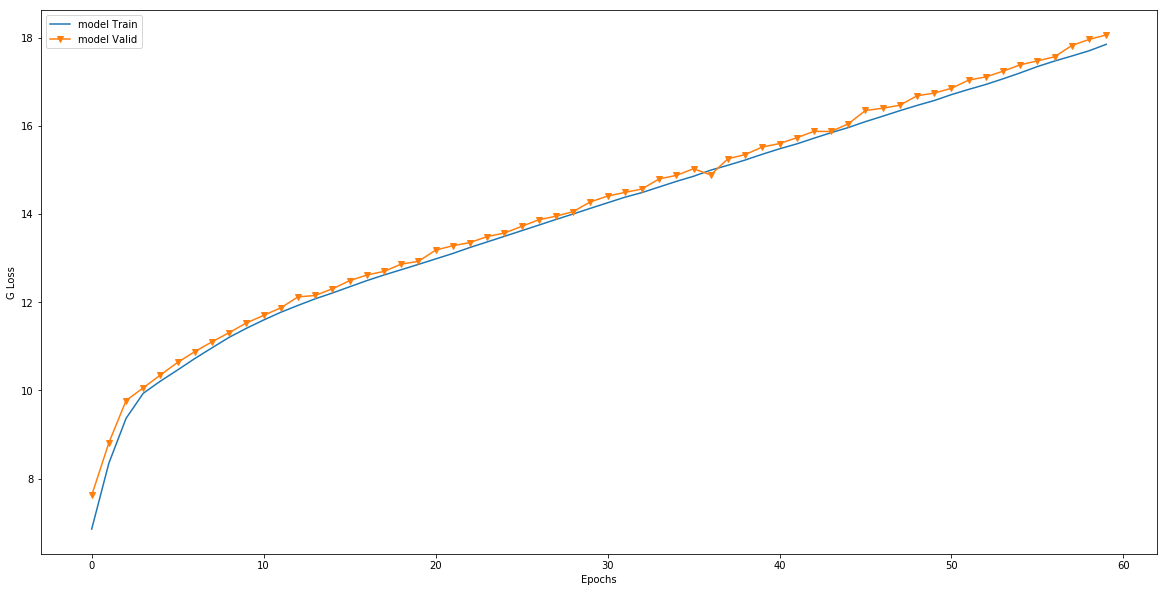

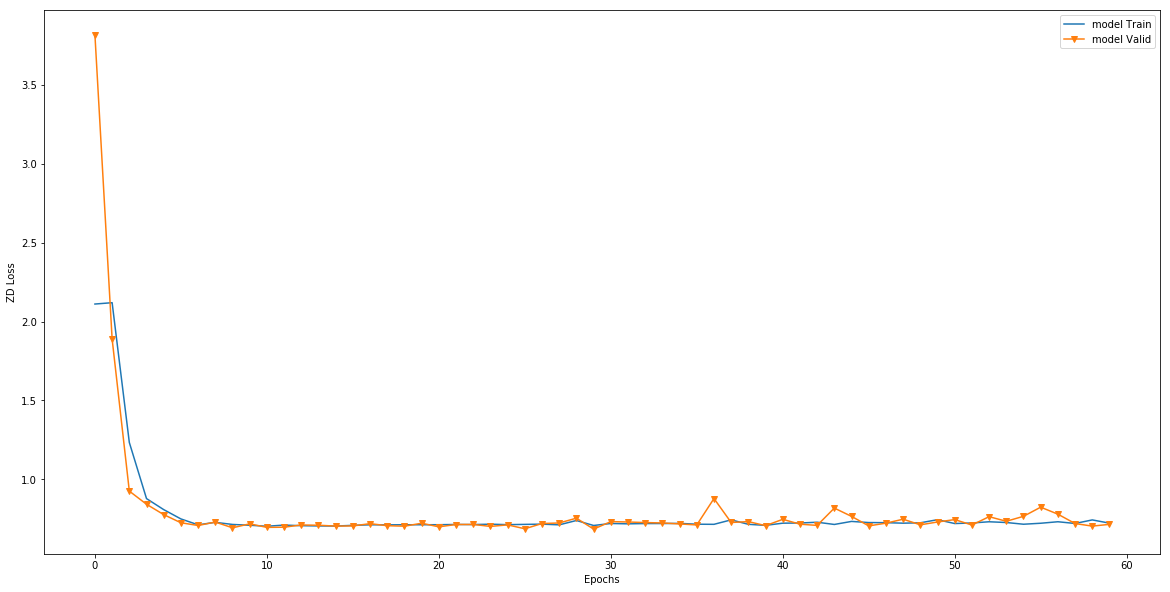

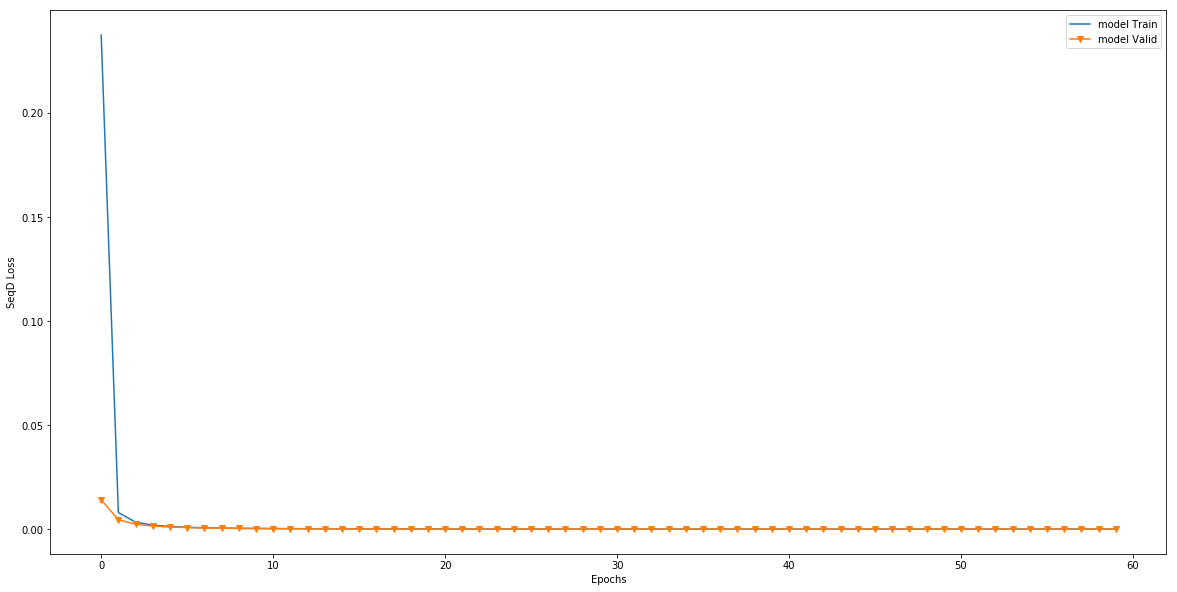

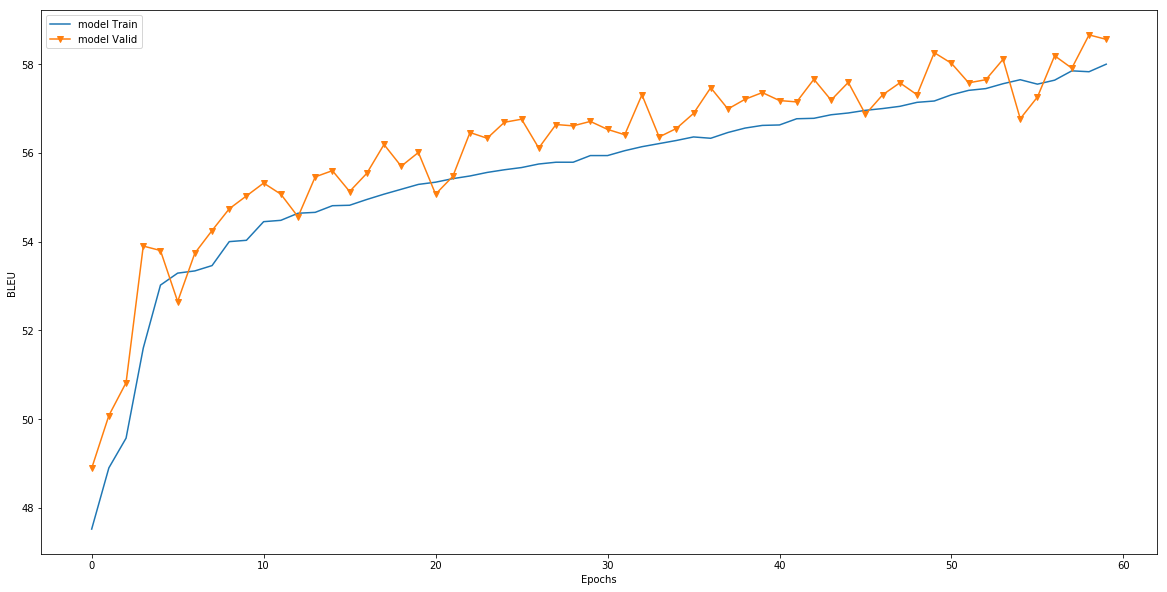

========== Start epoch 61 at 00:09:55 ==========
Epoch  61 Train: BLEU: 58.05, AE: 1.76413, G: 17.96831, ZD: 0.72423, SeqD: 0.00000  at 00:14:26
Epoch  61 Valid: BLEU: 57.77, AE: 1.99019, G: 18.25408, ZD: 0.71679, SeqD: 0.00000  at 00:14:35

Origin:
	an elderly woman sweeping outside on a sunny day <eos>

Decoded: a group of people dressed and one , one other
	

Random sample:

Decoded w. style E:
	you 're a little , i 'm a criminal
	i 'm just , my one is <eos>

Decoded w. style M:
	just the two of us , is are , he 's the time <eos>

========== Start epoch 62 at 00:14:35 ==========
Epoch  62 Train: BLEU: 58.05, AE: 1.76098, G: 18.09575, ZD: 0.72420, SeqD: 0.00000  at 00:19:11
Epoch  62 Valid: BLEU: 58.90, AE: 1.92122, G: 18.32940, ZD: 0.70355, SeqD: 0.00000  at 00:19:20

Origin:
	an oklahoma player is tackled playing football <eos>

Decoded: a group of people dressed and are are
	

Random sample:

Decoded w. style E:
	it 's my name , , it 's a world
	i do n't give a fuck to the one <eo

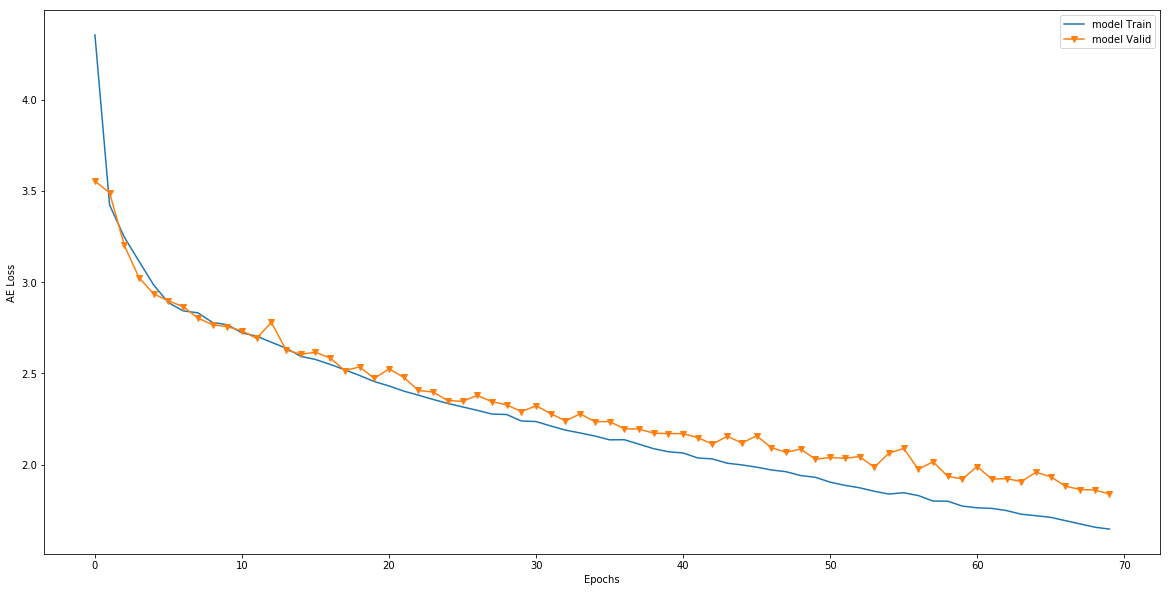

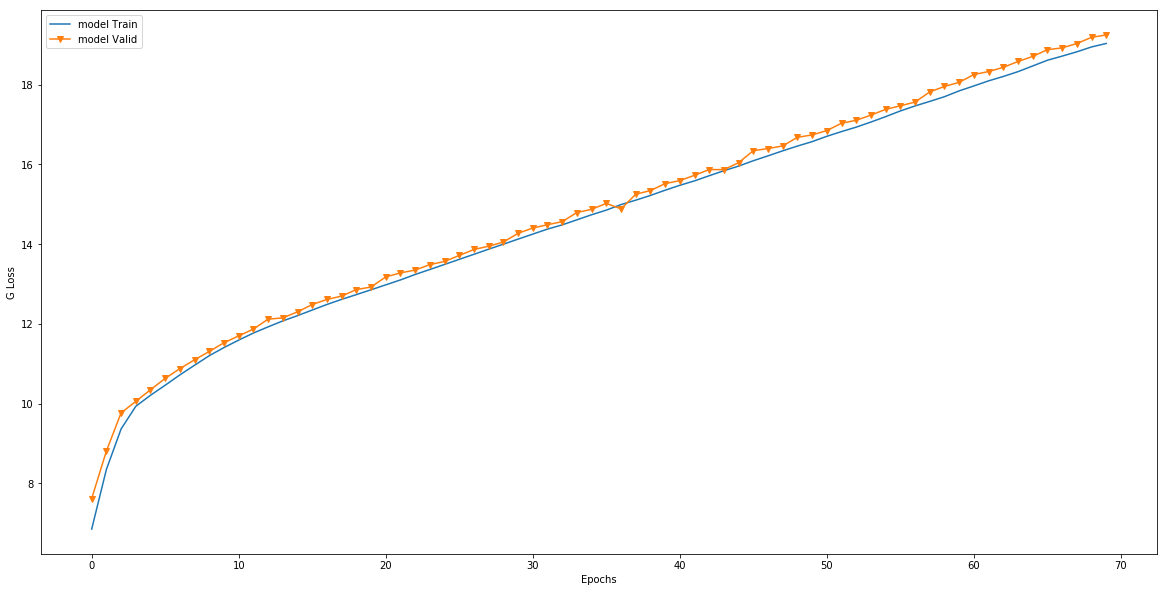

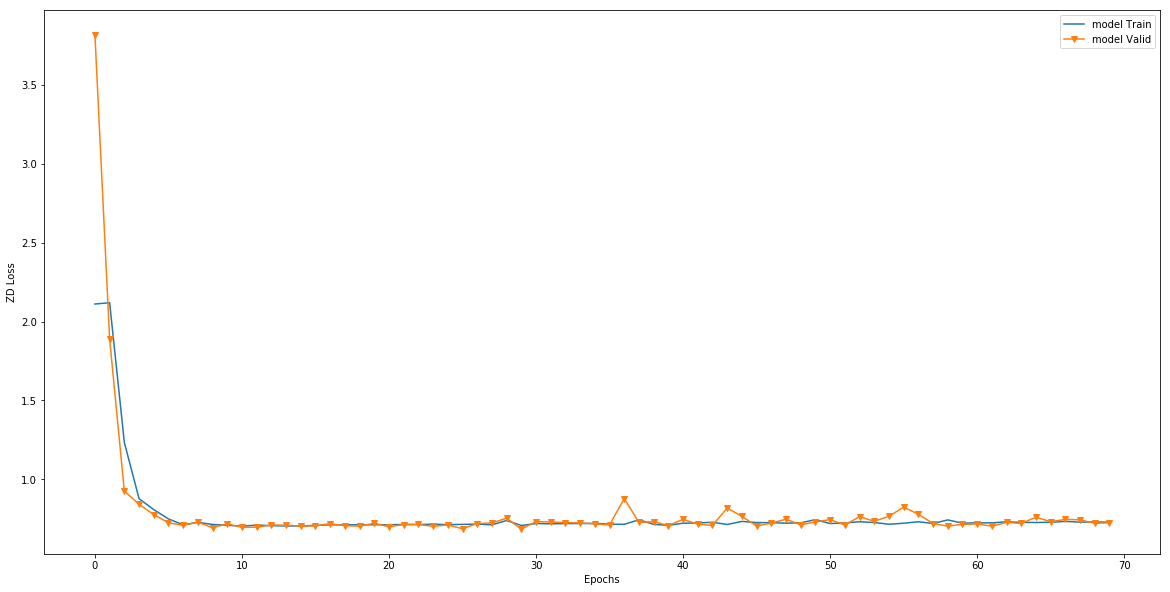

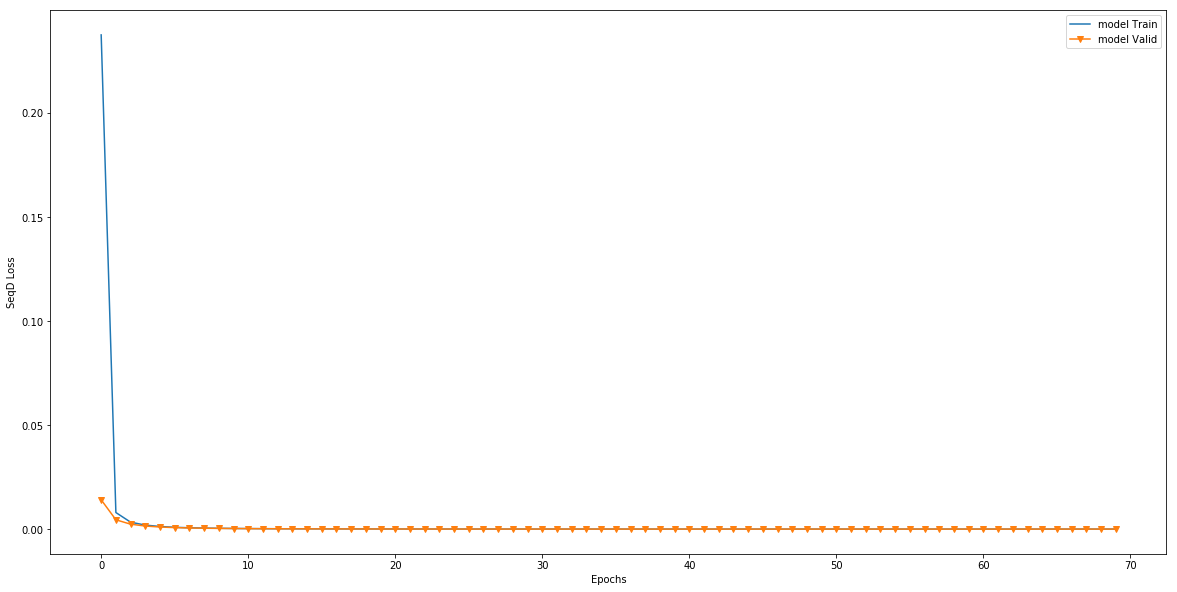

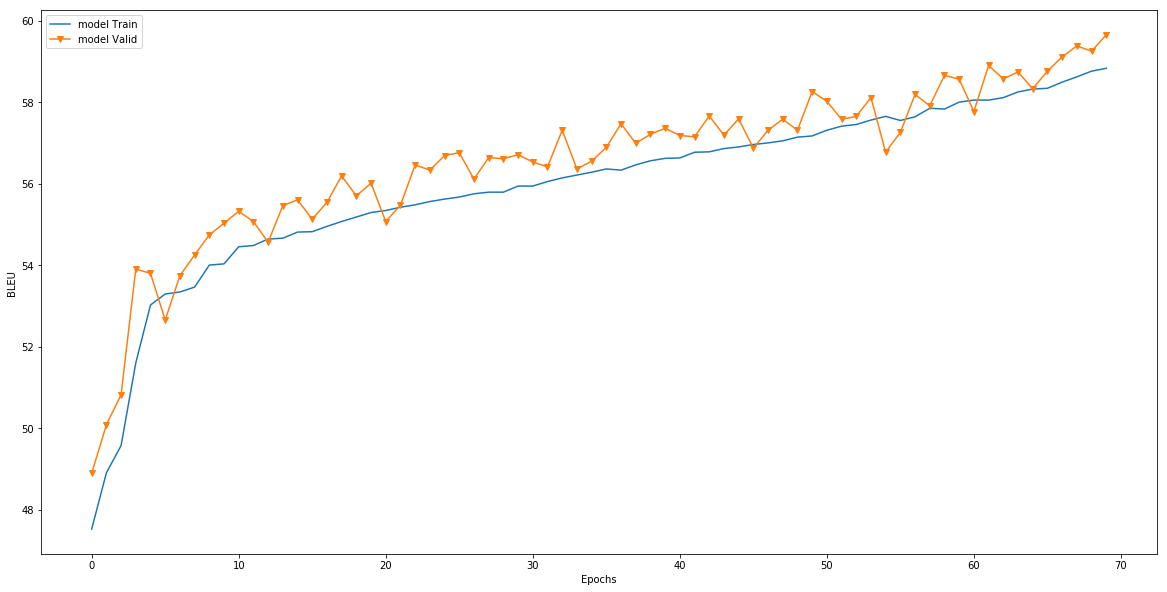

========== Start epoch 71 at 00:56:36 ==========
Epoch  71 Train: BLEU: 58.89, AE: 1.63846, G: 19.11272, ZD: 0.72169, SeqD: 0.00000  at 01:01:01
Epoch  71 Valid: BLEU: 59.00, AE: 1.86124, G: 19.38495, ZD: 0.70818, SeqD: 0.00000  at 01:01:08

Origin:
	what 'd you say ?
	did n't think i 'd remember ? <eos>

Decoded: but you know , i do n't know
	but i do n't know
	

Random sample:

Decoded w. style E:
	it 's not so bad ? 's not bad
	so the fuck that 's just gon na be famous <eos>

Decoded w. style M:
	it 's no time , i 'm going
	but it 's the buster i 'm not bad <eos>

========== Start epoch 72 at 01:01:08 ==========
Epoch  72 Train: BLEU: 58.91, AE: 1.63320, G: 19.20153, ZD: 0.72617, SeqD: 0.00000  at 01:05:33
Epoch  72 Valid: BLEU: 58.78, AE: 1.86827, G: 19.48835, ZD: 0.70551, SeqD: 0.00000  at 01:05:41

Origin:
	a man with a large plant reads a newspaper about how someone besides him is an idiot . <eos>

Decoded: a man in a suit , a child looking at the camera to be the ball while he 

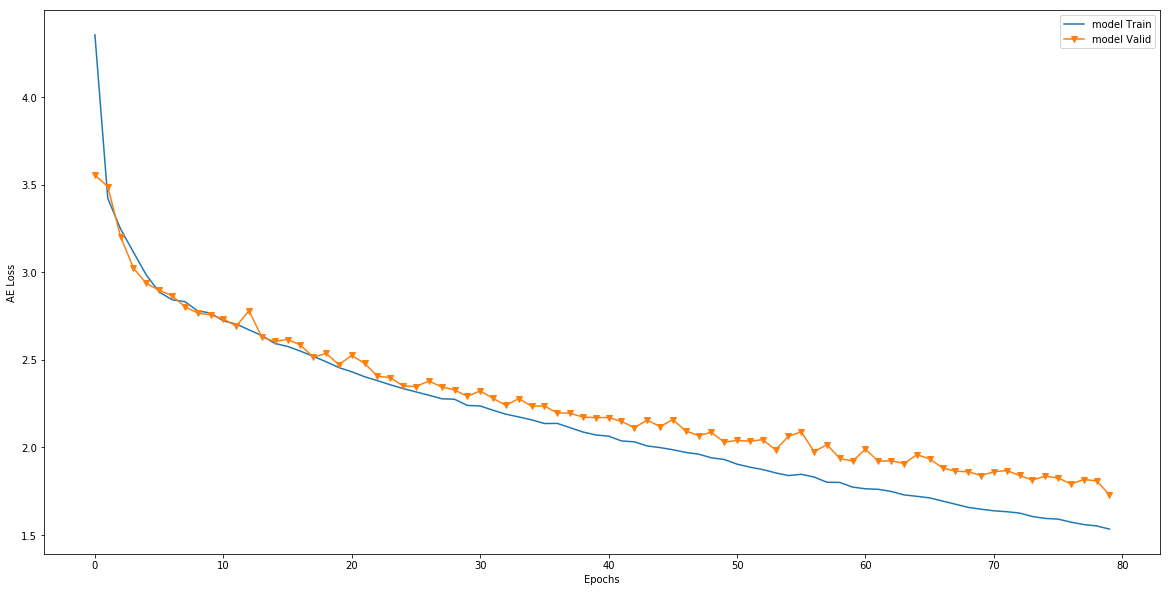

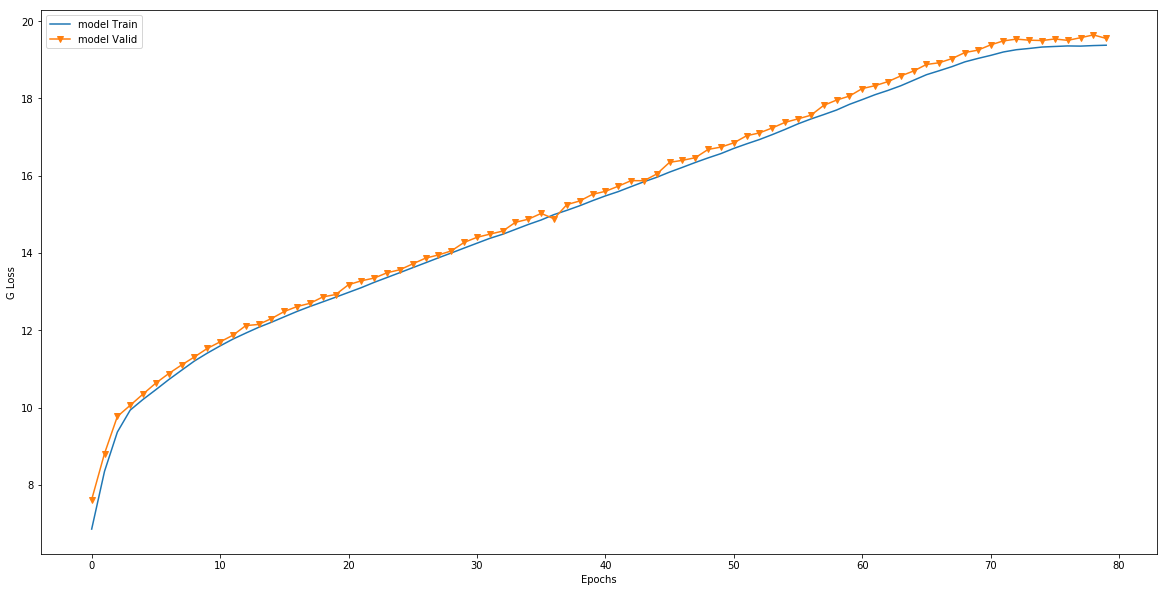

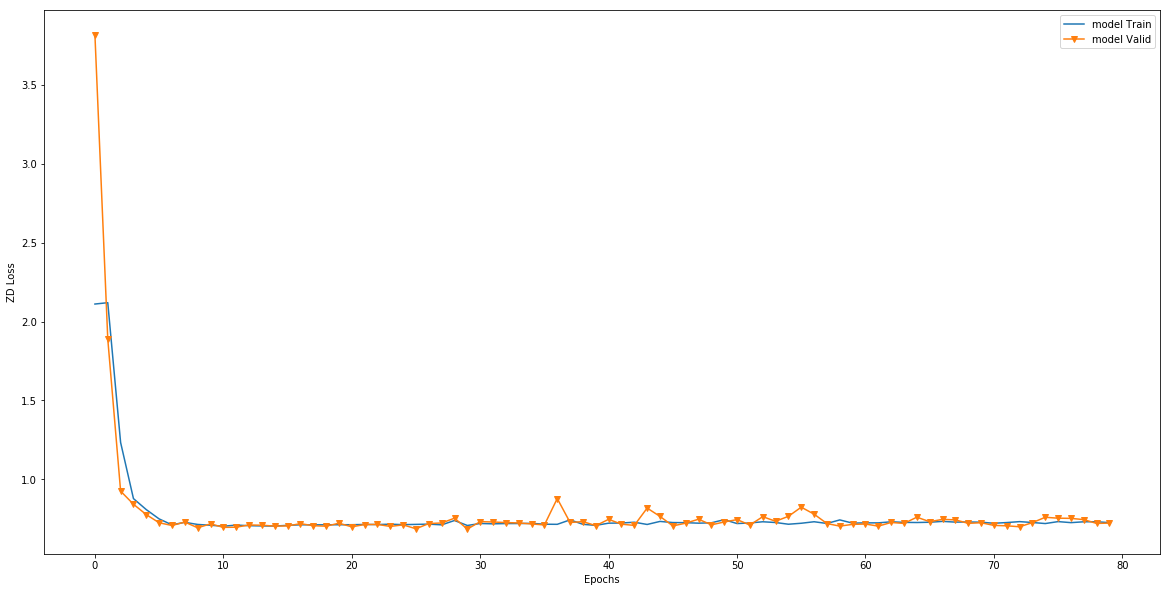

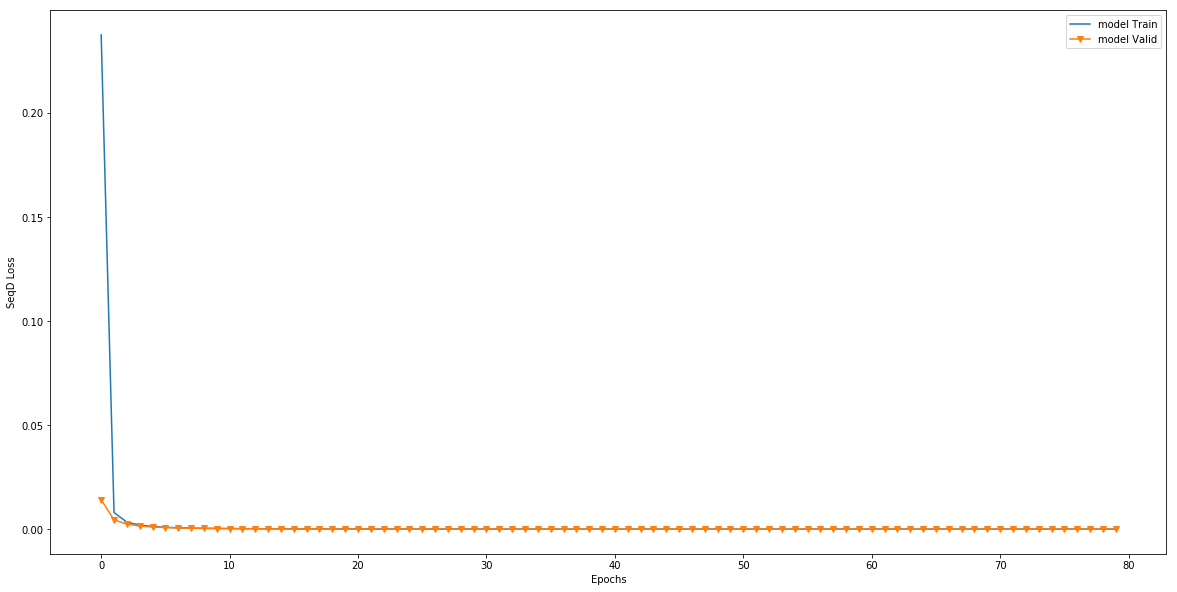

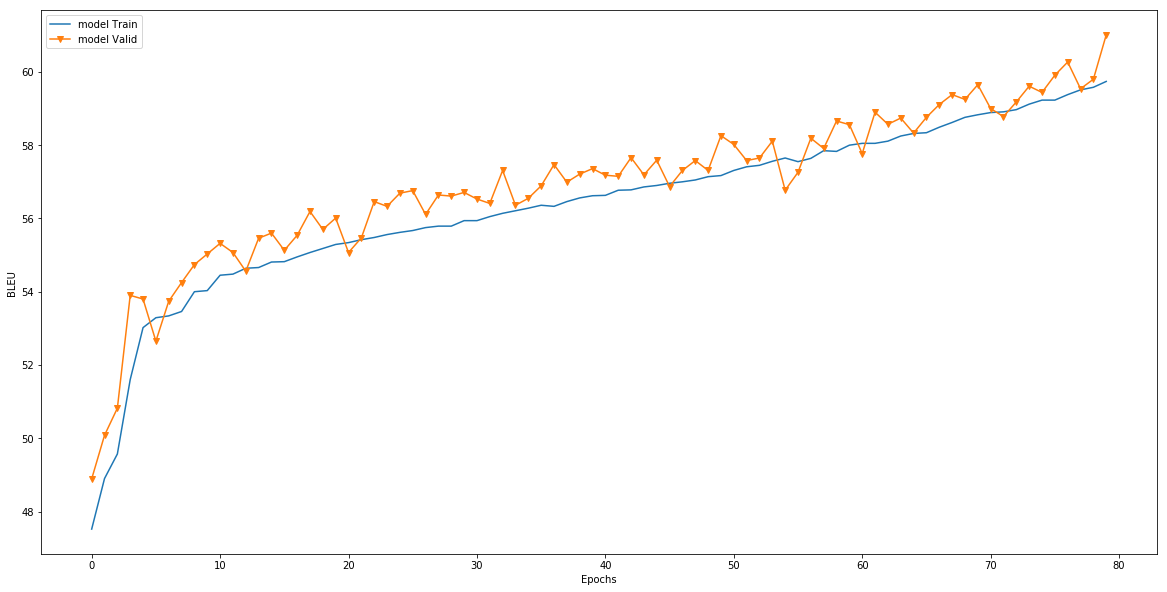

========== Start epoch 81 at 01:41:56 ==========
Epoch  81 Train: BLEU: 59.81, AE: 1.52643, G: 19.38390, ZD: 0.72249, SeqD: 0.00000  at 01:46:18
Epoch  81 Valid: BLEU: 60.22, AE: 1.76699, G: 19.57261, ZD: 0.74185, SeqD: 0.00000  at 01:46:25

Origin:
	the sixth letter there 's a bomb threat in our building
	this crazy mother fucker 's really tryin to kill me <eos>

Decoded: the morning that clouds up the same masses in the air
	and it 's the way that i do n't give a
	

Random sample:

Decoded w. style E:
	we 're my ones
	it 's my time <eos>

Decoded w. style M:
	people the people
	two men are taking the <eos>

========== Start epoch 82 at 01:46:26 ==========
Epoch  82 Train: BLEU: 59.82, AE: 1.52279, G: 19.38154, ZD: 0.73627, SeqD: 0.00000  at 01:50:51
Epoch  82 Valid: BLEU: 60.28, AE: 1.75971, G: 19.67977, ZD: 0.69584, SeqD: 0.00000  at 01:50:59

Origin:
	a man plays makeshift drums on white buckets in the snow . <eos>

Decoded: a man with an hair standing in front of a white ball on
	

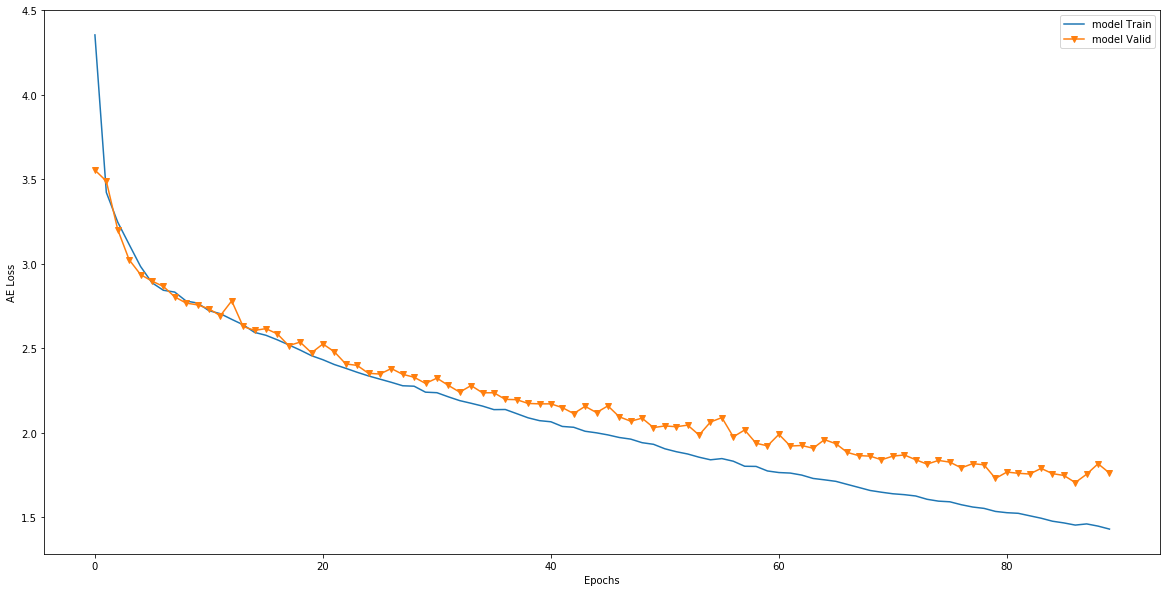

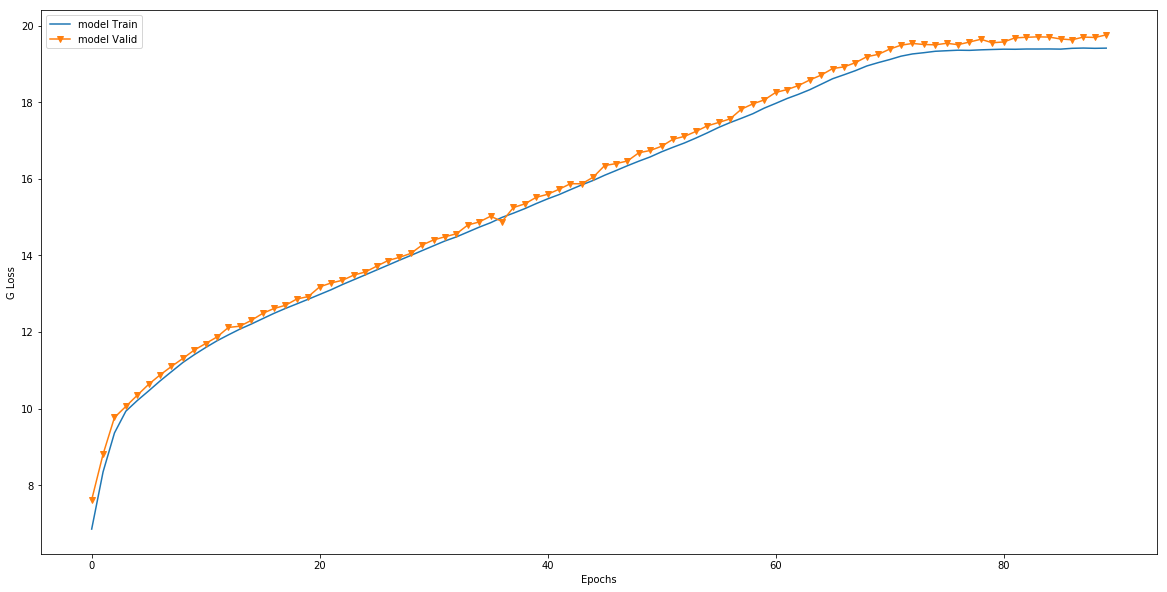

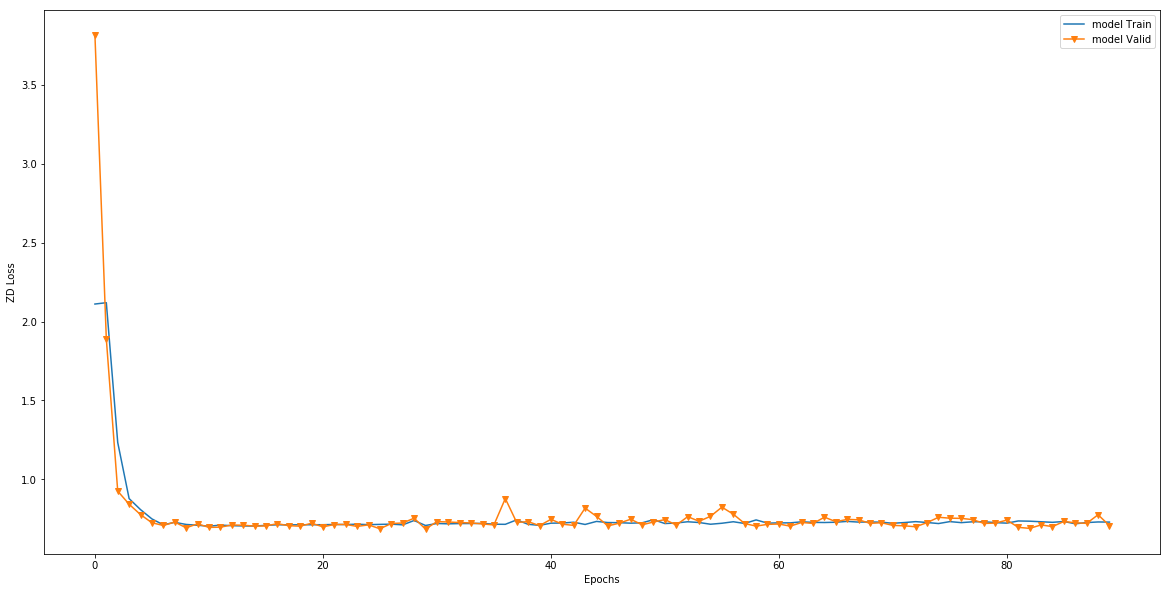

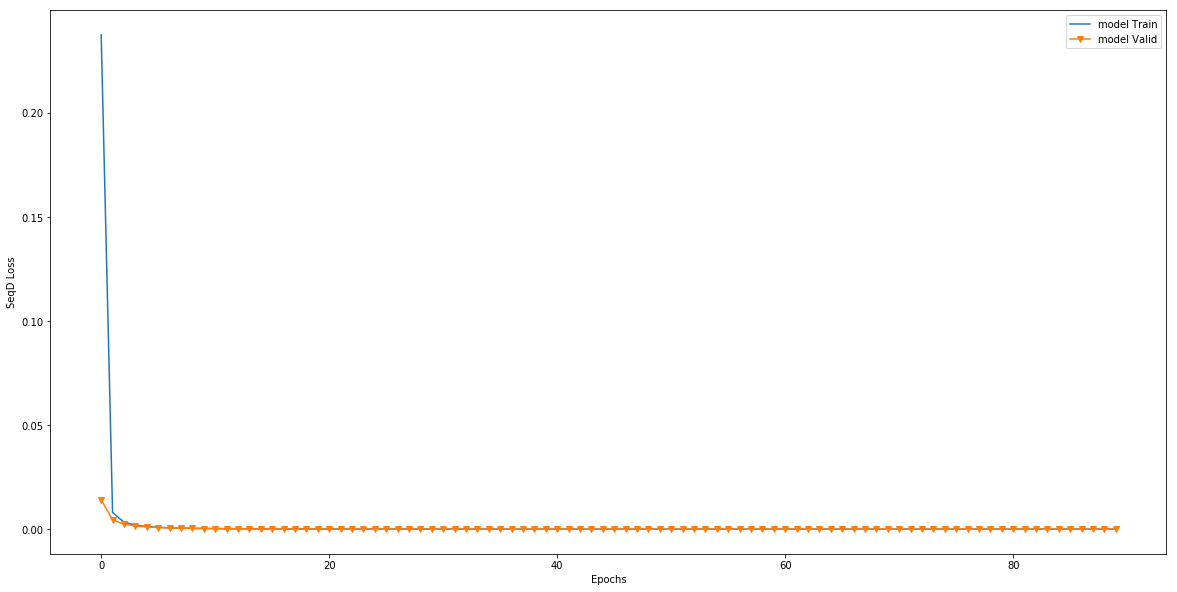

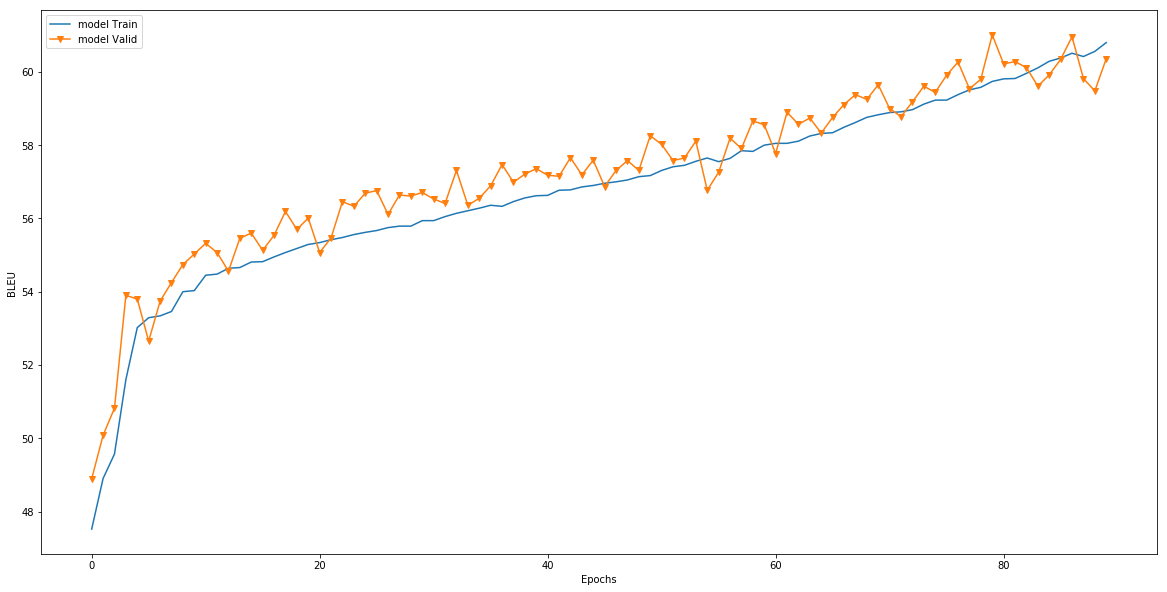

========== Start epoch 91 at 02:27:15 ==========
Epoch  91 Train: BLEU: 60.72, AE: 1.43151, G: 19.41803, ZD: 0.73021, SeqD: 0.00000  at 02:31:39
Epoch  91 Valid: BLEU: 61.22, AE: 1.68553, G: 19.73282, ZD: 0.68972, SeqD: 0.00000  at 02:31:47

Origin:
	while the bullets break your bones up like christmas toys
	if i go solo , i 'm doin a song with bolo <eos>

Decoded: put the mic from the top of the hugest that
	i 'm not gon na , i 'm a buck on up <eos>
	

Random sample:

Decoded w. style E:
	and a baby ,
	this is my body on my headphones <eos>

Decoded w. style M:
	a man with an hair is over the window and . <eos>

========== Start epoch 92 at 02:31:48 ==========
Epoch  92 Train: BLEU: 60.77, AE: 1.42787, G: 19.40430, ZD: 0.75626, SeqD: 0.00000  at 02:36:11
Epoch  92 Valid: BLEU: 60.77, AE: 1.69617, G: 19.66200, ZD: 0.74880, SeqD: 0.00000  at 02:36:18

Origin:
	a.k.a . the army
	shady records <eos>

Decoded: put the mic and walk to get the
	

Random sample:

Decoded w. style E:
	and you 

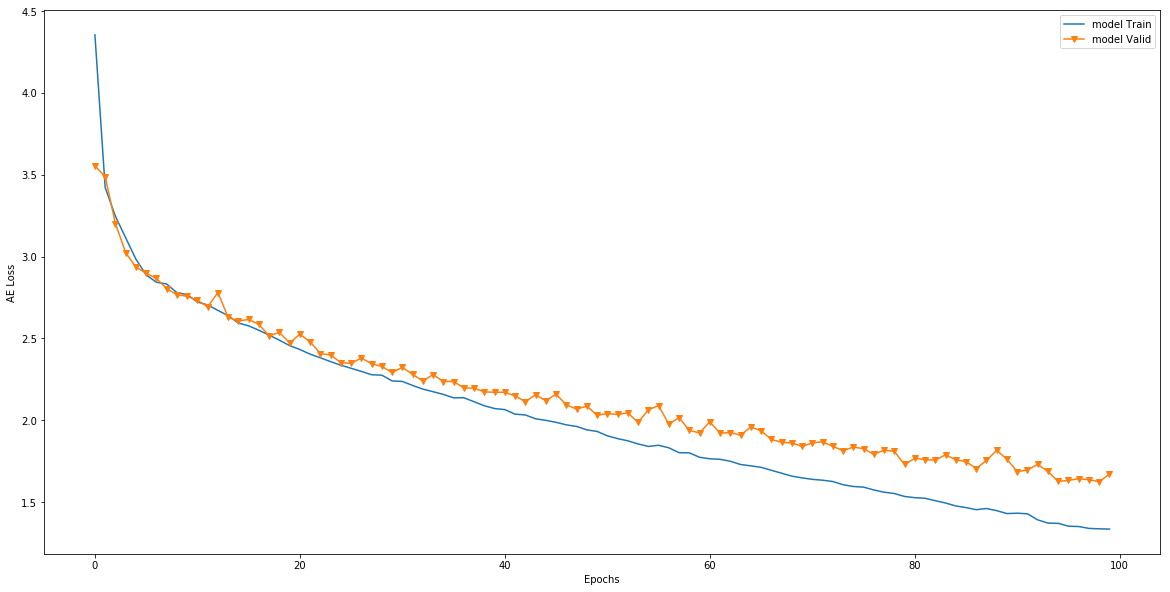

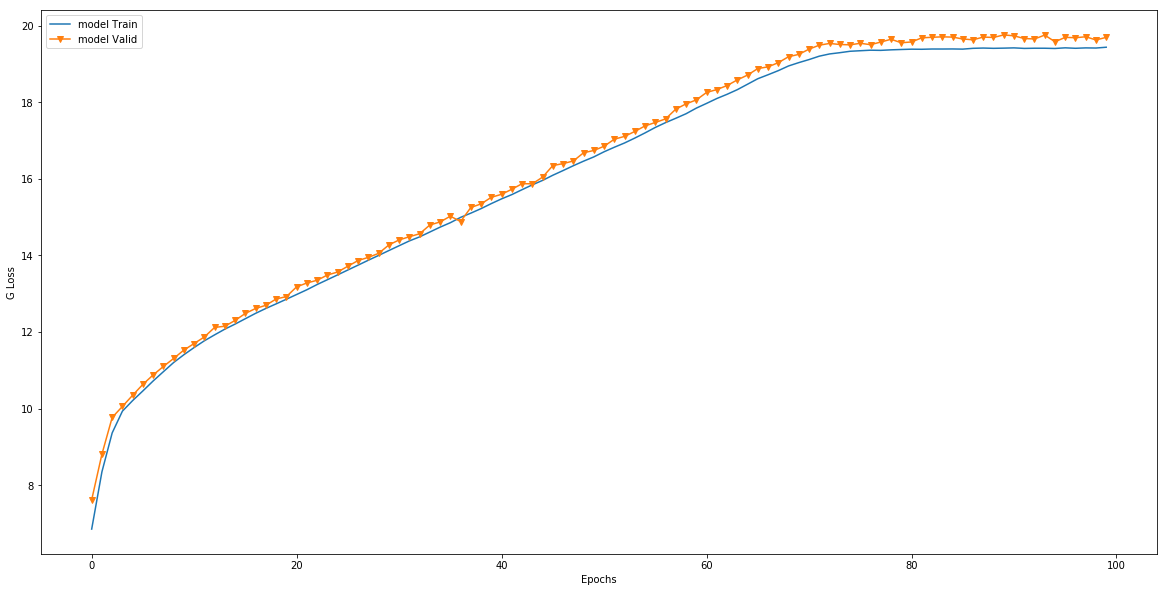

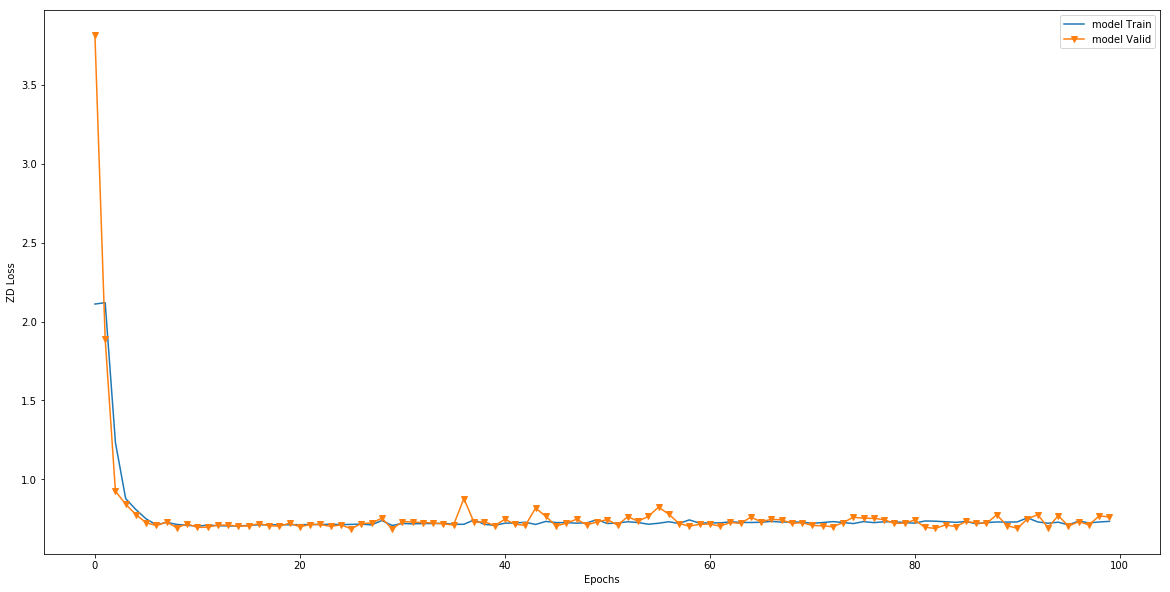

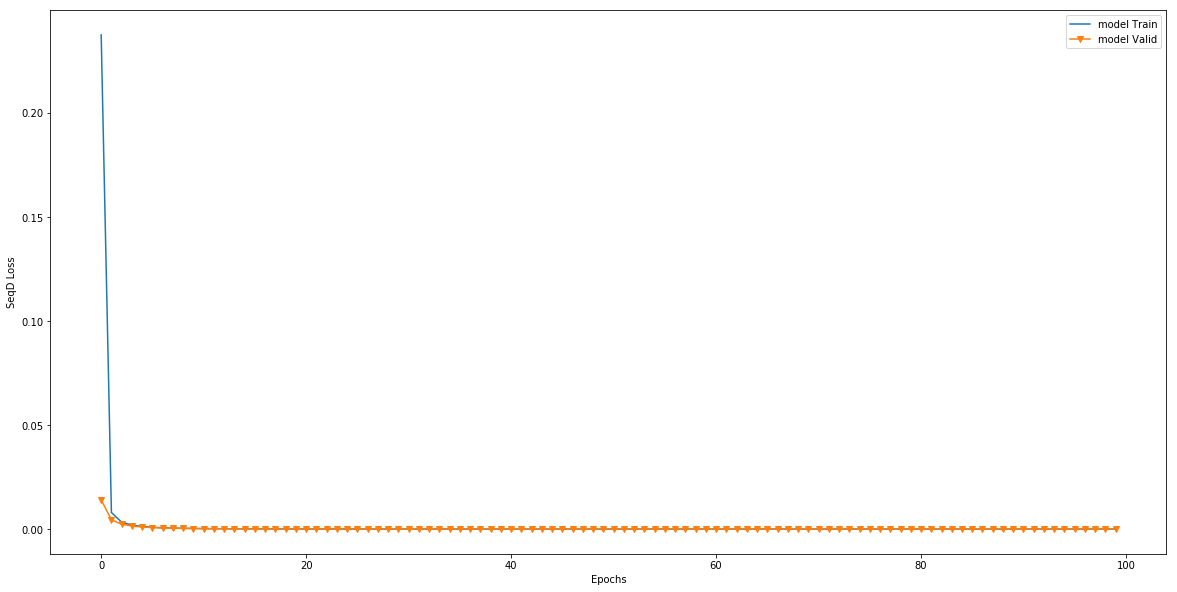

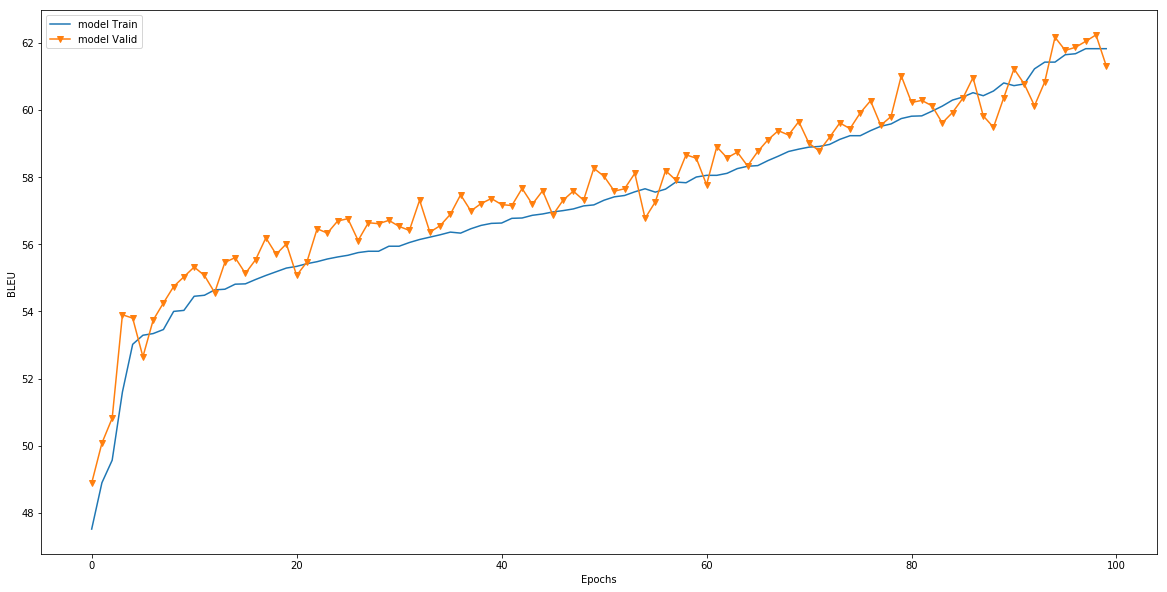

========== Start epoch 101 at 03:12:37 ==========
Epoch 101 Train: BLEU: 62.08, AE: 1.31626, G: 19.44198, ZD: 0.71408, SeqD: 0.00000  at 03:17:03
Epoch 101 Valid: BLEU: 61.56, AE: 1.64051, G: 19.78459, ZD: 0.68764, SeqD: 0.00000  at 03:17:10

Origin:
	or too early ... wait a minute there goes shirley ...
	the girly i fucked last year when her hair was curly <eos>

Decoded: but there 's so the way the same , it 's been
	but it 's all late of it 's a same day
	

Random sample:

Decoded w. style E:
	my little bit ,
	the two of us and vibrance <eos>

Decoded w. style M:
	the little boy catches the ball in front of a waterfall . <eos>

========== Start epoch 102 at 03:17:10 ==========
Epoch 102 Train: BLEU: 61.77, AE: 1.34077, G: 19.44731, ZD: 0.74017, SeqD: 0.00000  at 03:21:35
Epoch 102 Valid: BLEU: 61.80, AE: 1.62261, G: 19.71988, ZD: 0.73294, SeqD: 0.00000  at 03:21:44

Origin:
	two men wearing white cowboy hats . <eos>

Decoded: two people in blue shirts and blue shirts
	

Random sampl

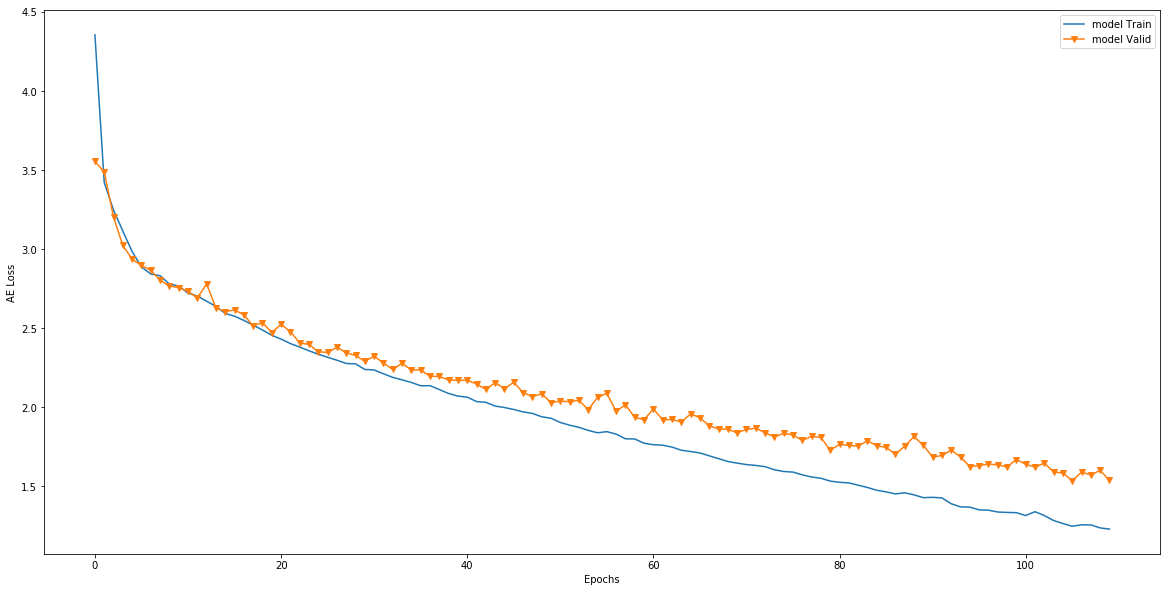

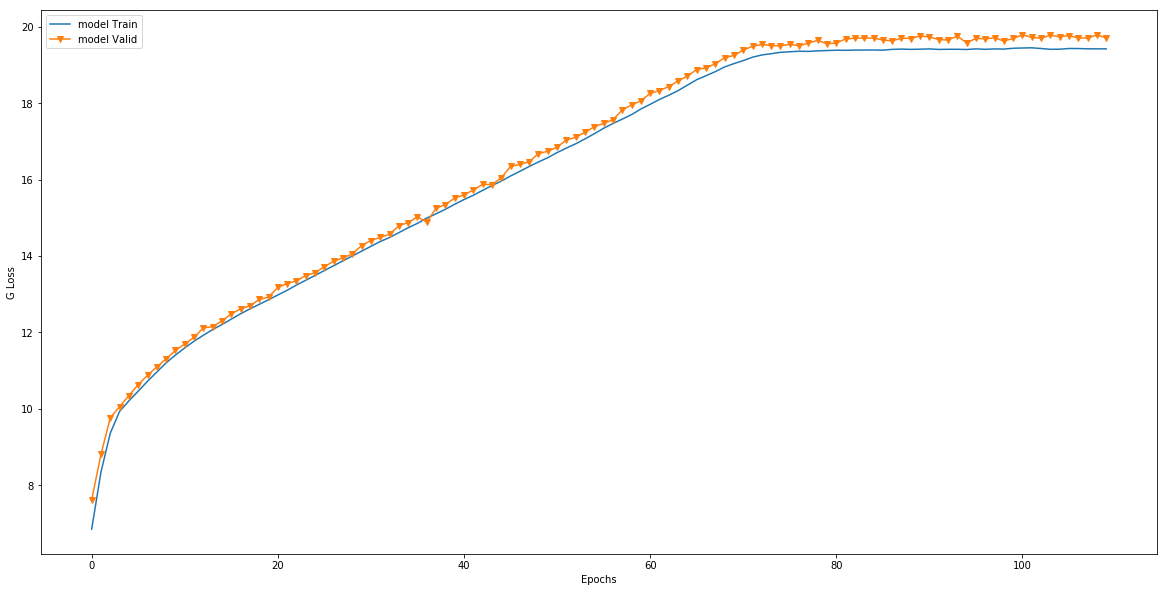

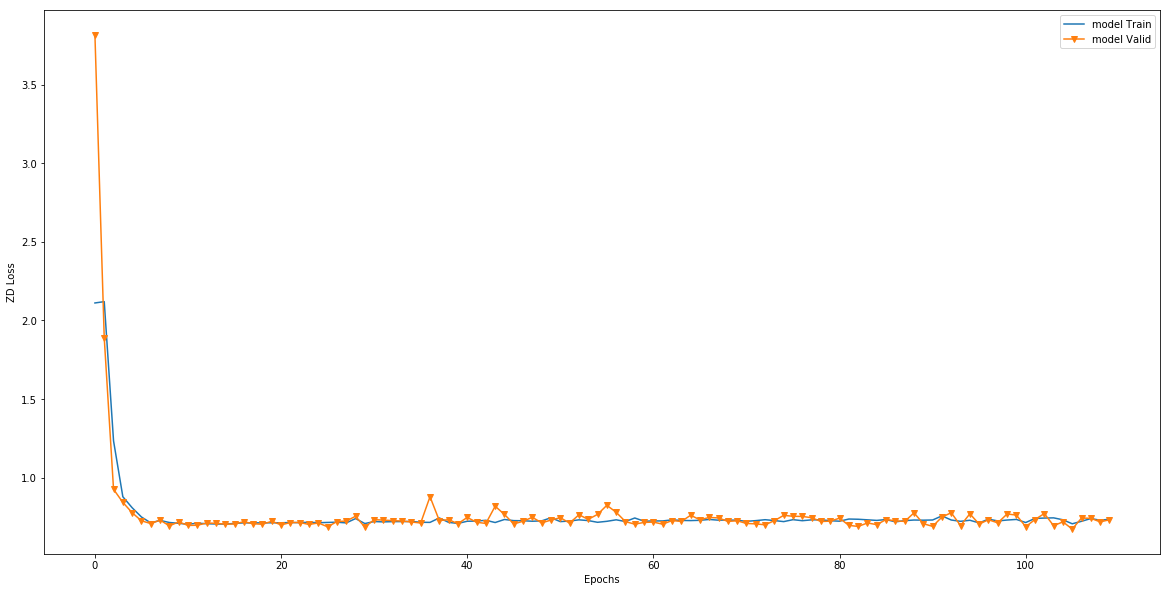

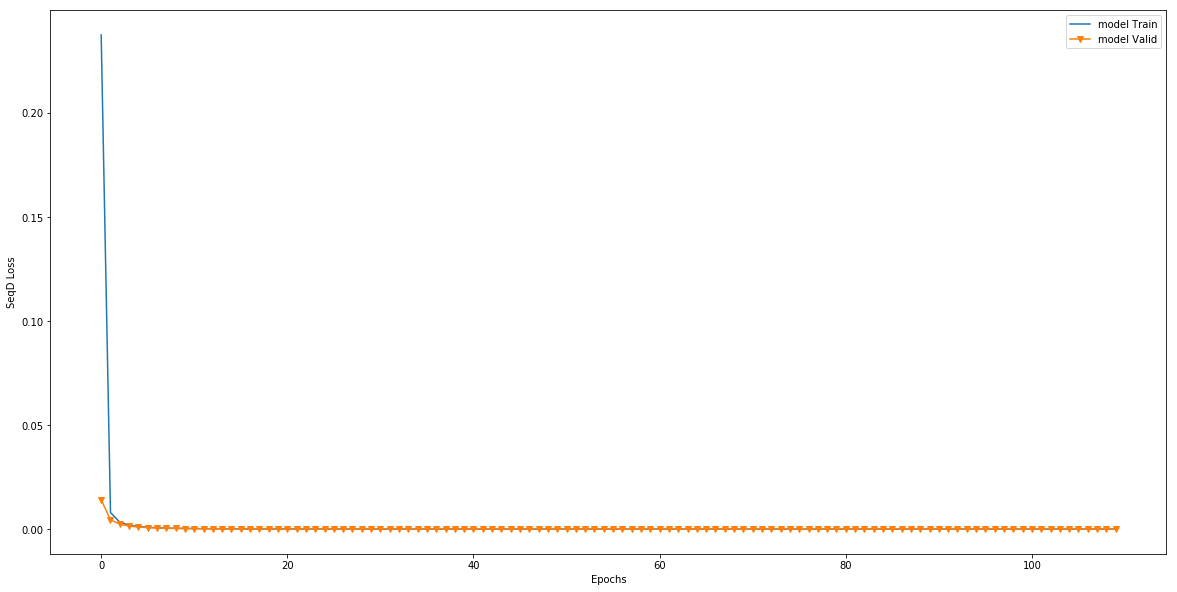

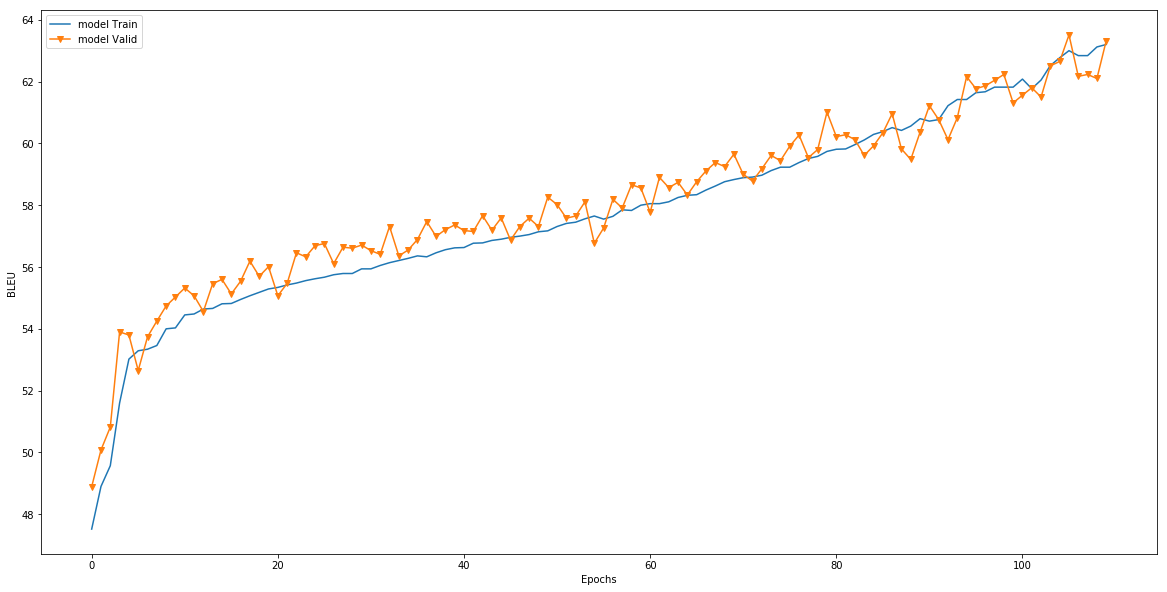

========== Start epoch 111 at 03:58:45 ==========
Epoch 111 Train: BLEU: 63.35, AE: 1.21935, G: 19.41168, ZD: 0.73388, SeqD: 0.00000  at 04:03:15
Epoch 111 Valid: BLEU: 61.36, AE: 1.68617, G: 19.87424, ZD: 0.73331, SeqD: 0.00000  at 04:03:23

Origin:
	ca n't forget what you said
	and i never <eos>

Decoded: if i 'm not you you like this is what i
	

Random sample:

Decoded w. style E:
	and this whole rhapsody , your heart
	put a fuck up , climax <eos>

Decoded w. style M:
	a little girl holds a newspaper down an skateboard with the skateboard . <eos>

========== Start epoch 112 at 04:03:23 ==========
Epoch 112 Train: BLEU: 63.48, AE: 1.20972, G: 19.43931, ZD: 0.72063, SeqD: 0.00000  at 04:07:52
Epoch 112 Valid: BLEU: 62.75, AE: 1.56586, G: 19.61333, ZD: 0.81779, SeqD: 0.00000  at 04:08:00

Origin:
	two firemen , dressed in uniforms , are walking out of the firetruck onto the sidewalk . <eos>

Decoded: two men dressed and white , standing outside at a dance of water on the road . <eos>


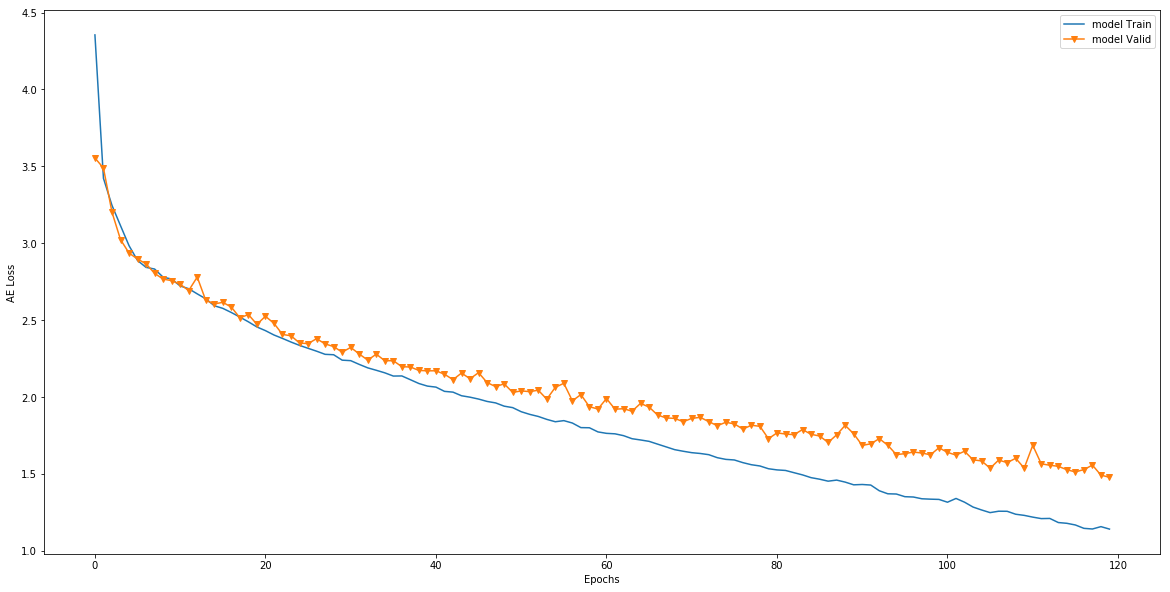

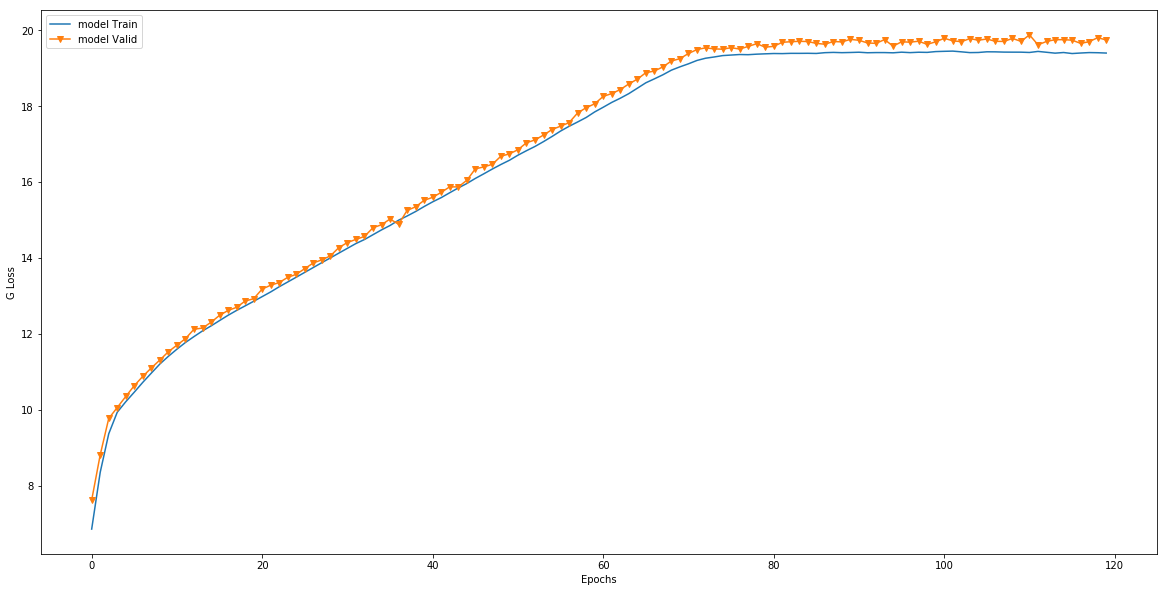

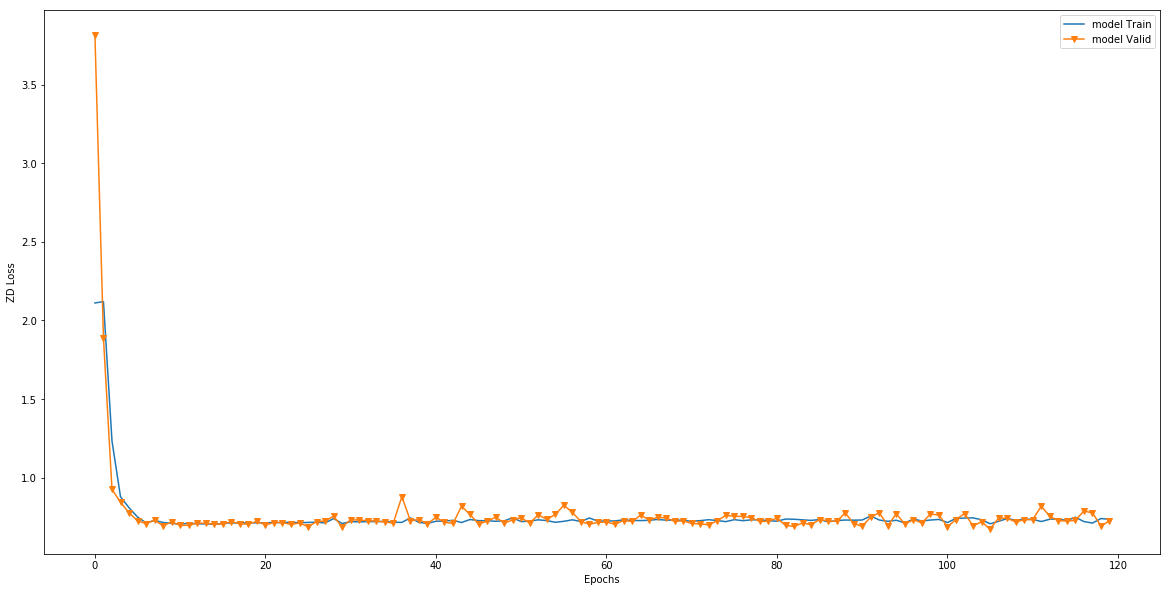

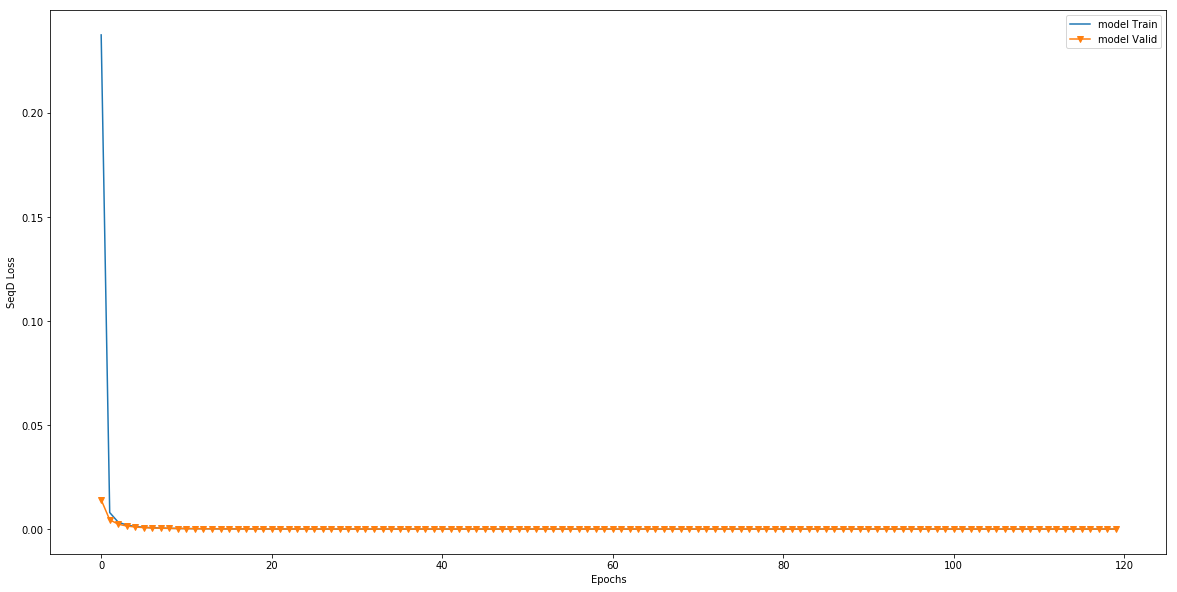

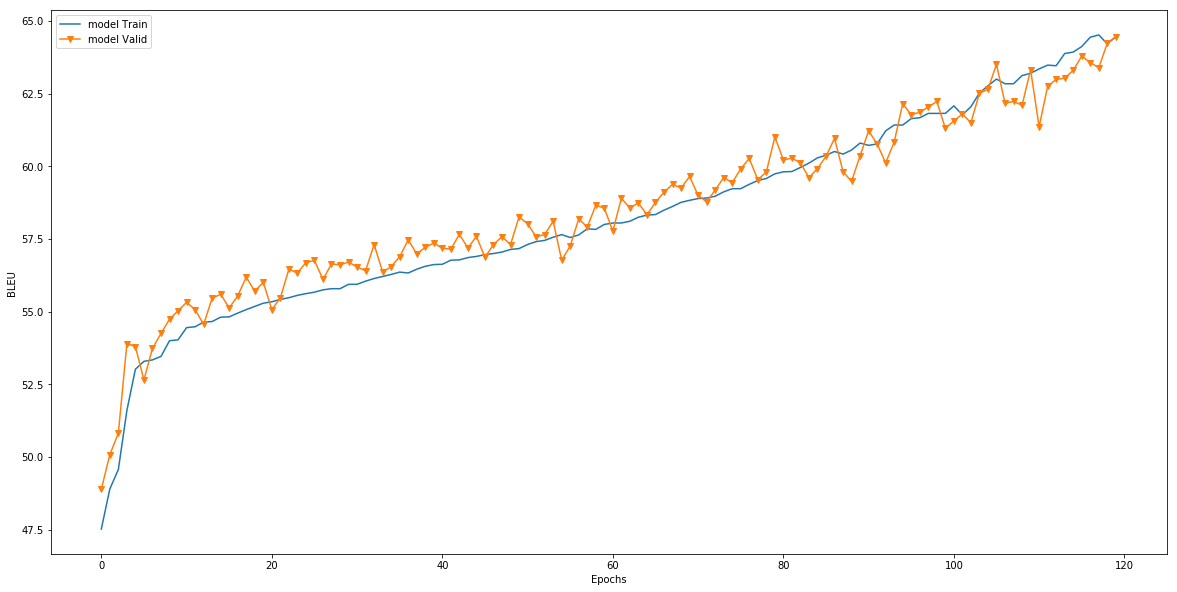

========== Start epoch 121 at 04:44:25 ==========
Epoch 121 Train: BLEU: 64.66, AE: 1.13000, G: 19.39535, ZD: 0.73609, SeqD: 0.00000  at 04:48:50
Epoch 121 Valid: BLEU: 64.18, AE: 1.47644, G: 19.71386, ZD: 0.73662, SeqD: 0.00000  at 04:48:57

Origin:
	the man passing the door is wearing a white shirt and black running pants with white stripes down the side . <eos>

Decoded: a large male rider is riding a red and white and white , holding a red ball into the background . <eos>
	

Random sample:

Decoded w. style E:
	what 's not so bad ?
	we 're gon na get together then it 's like it 's so <eos>

Decoded w. style M:
	who 's so bad when i 'm just partying
	so this is it 's over for all it <eos>

========== Start epoch 122 at 04:48:57 ==========
Epoch 122 Train: BLEU: 64.77, AE: 1.12127, G: 19.38156, ZD: 0.74327, SeqD: 0.00000  at 04:53:22
Epoch 122 Valid: BLEU: 64.42, AE: 1.48187, G: 19.72775, ZD: 0.73499, SeqD: 0.00000  at 04:53:29

Origin:
	mase in your face bitch , cry now pussy
	this 

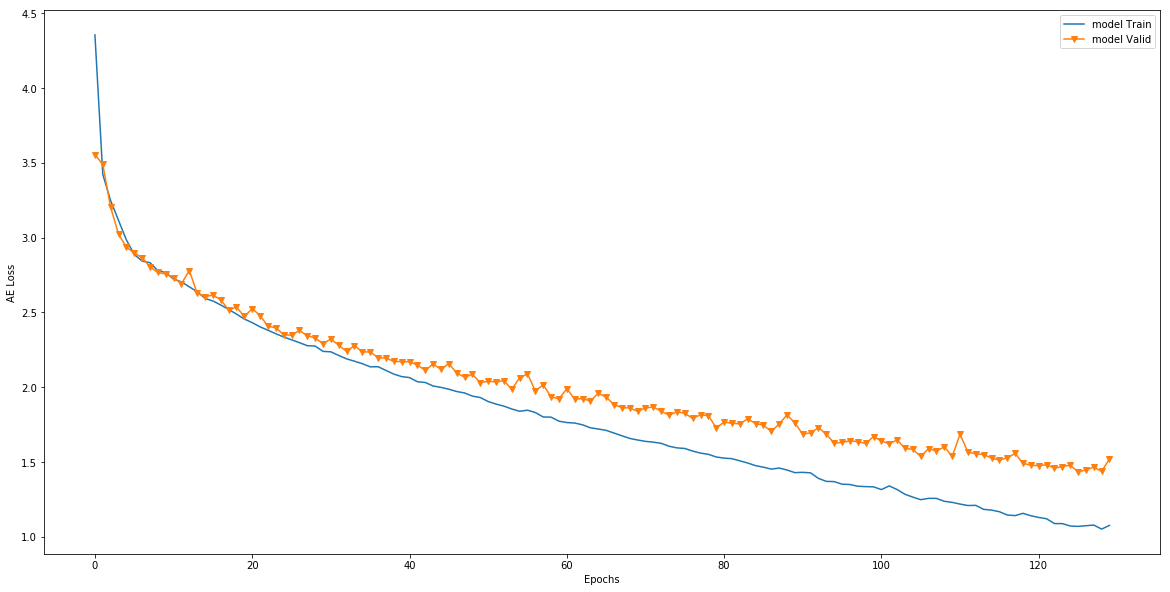

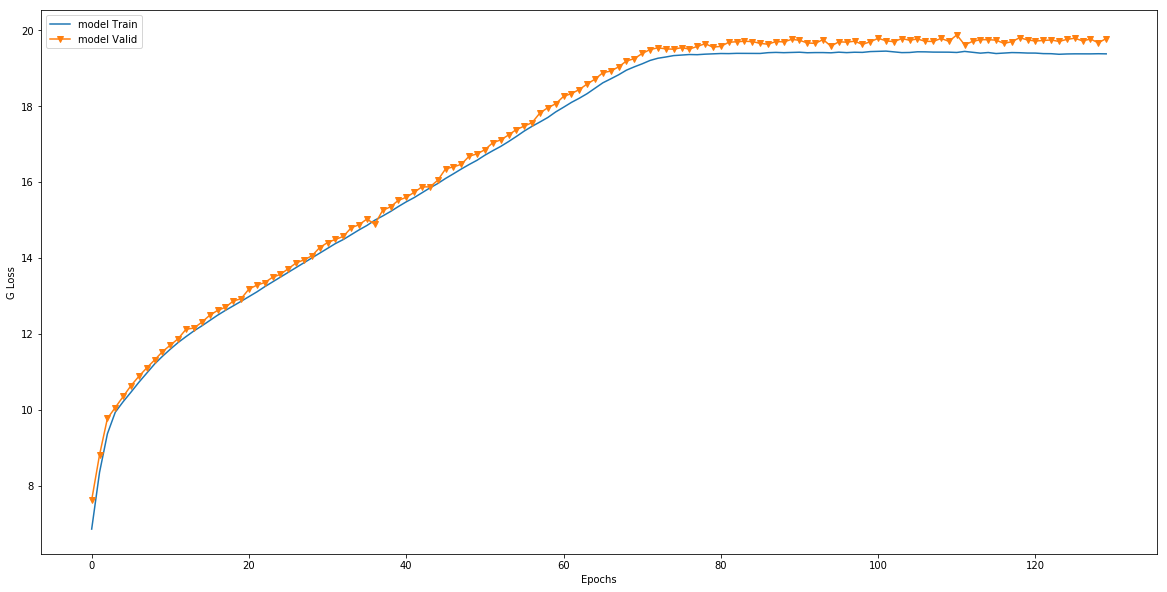

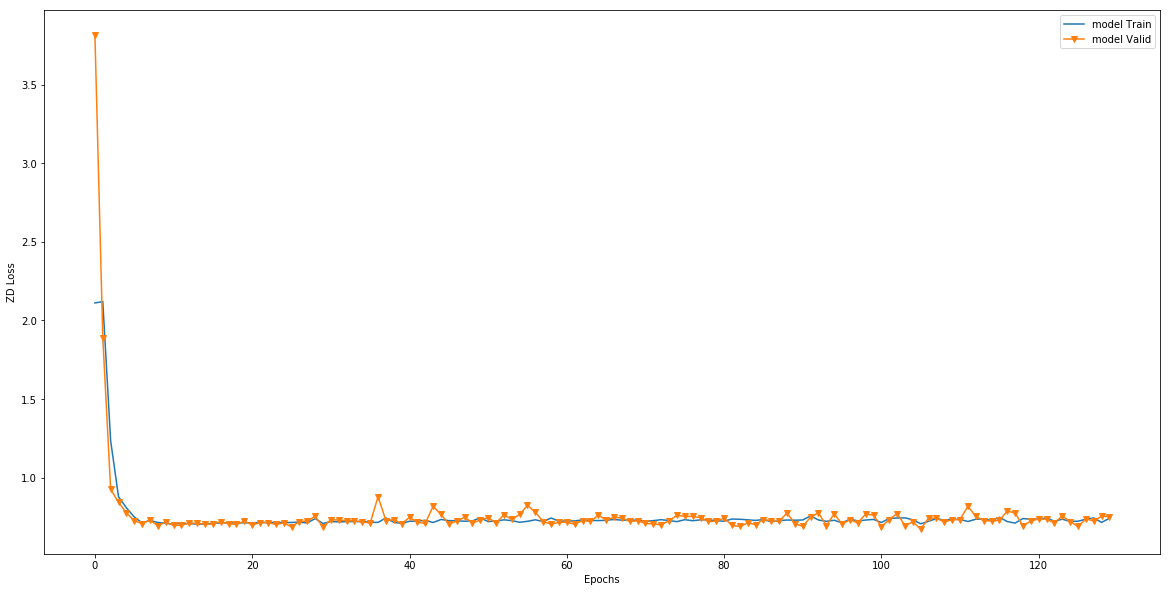

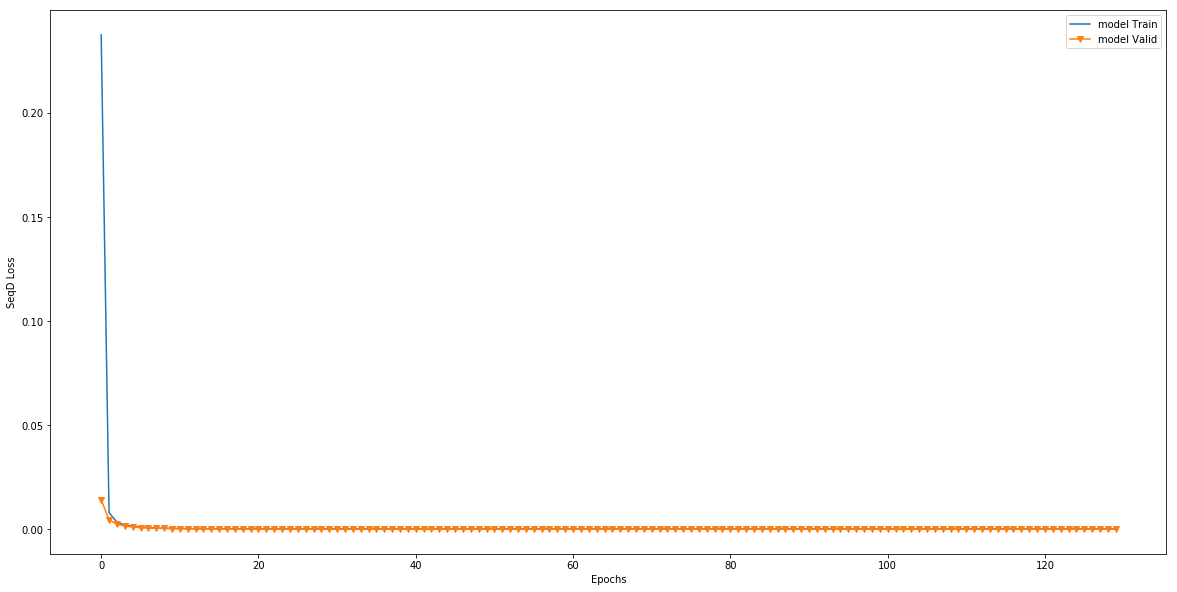

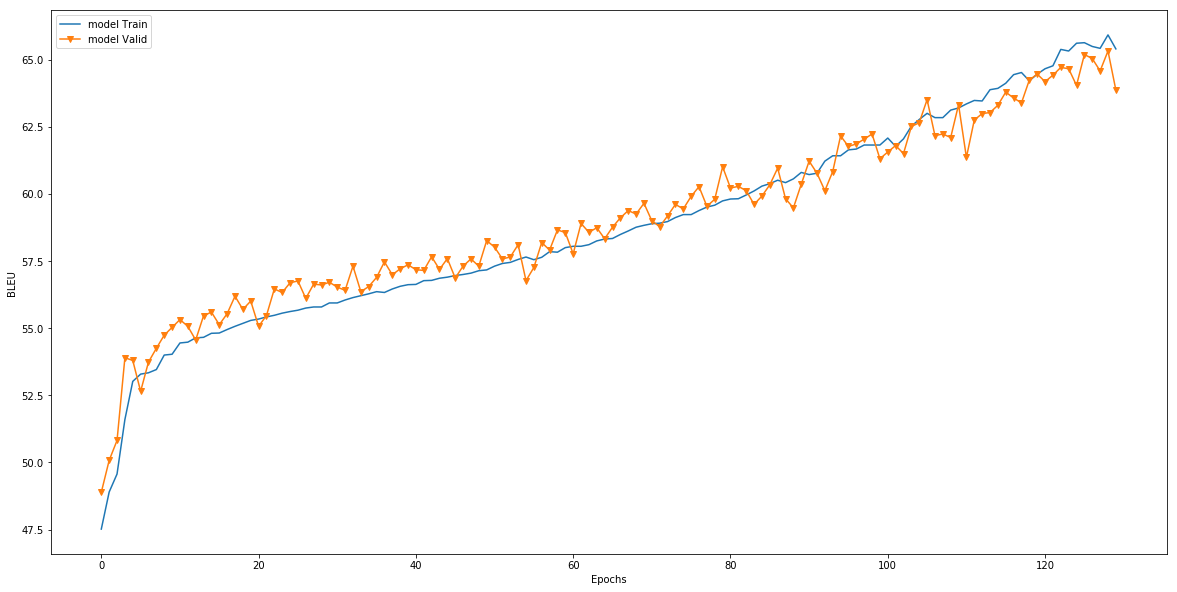

========== Start epoch 131 at 05:29:53 ==========
Epoch 131 Train: BLEU: 66.12, AE: 1.03972, G: 19.33893, ZD: 0.74319, SeqD: 0.00000  at 05:34:17
Epoch 131 Valid: BLEU: 65.64, AE: 1.41679, G: 19.78034, ZD: 0.69294, SeqD: 0.00000  at 05:34:24

Origin:
	a woman in a straw hat standing in front of a table covered in miscellaneous items . <eos>

Decoded: a woman in a hat holding a bicycle with an orange bag in front of an audience .
	

Random sample:

Decoded w. style E:
	in this motherfucker that 's it
	all it i 've been over the whole list that 's <eos>

Decoded w. style M:
	a man smiles as the other man to his left on a horse . <eos>

========== Start epoch 132 at 05:34:24 ==========
Epoch 132 Train: BLEU: 66.51, AE: 1.01947, G: 19.33433, ZD: 0.73524, SeqD: 0.00000  at 05:38:49
Epoch 132 Valid: BLEU: 65.39, AE: 1.41951, G: 19.69562, ZD: 0.74148, SeqD: 0.00000  at 05:38:56

Origin:
	two young men clutch rags in their hands as a elderly man tells them how to clean the large cross . <eos>


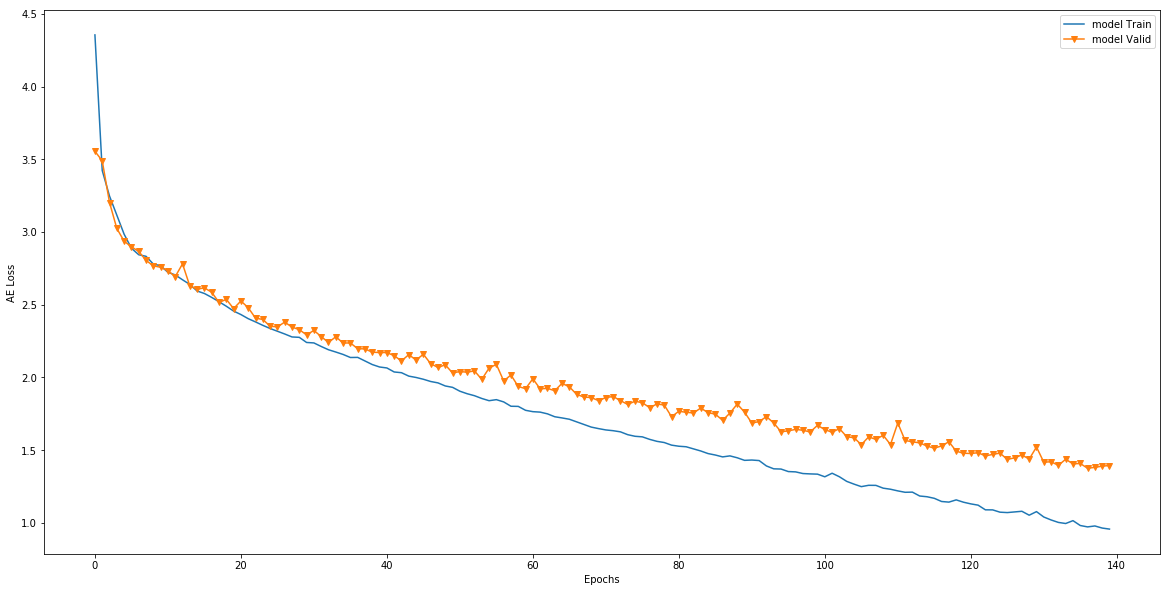

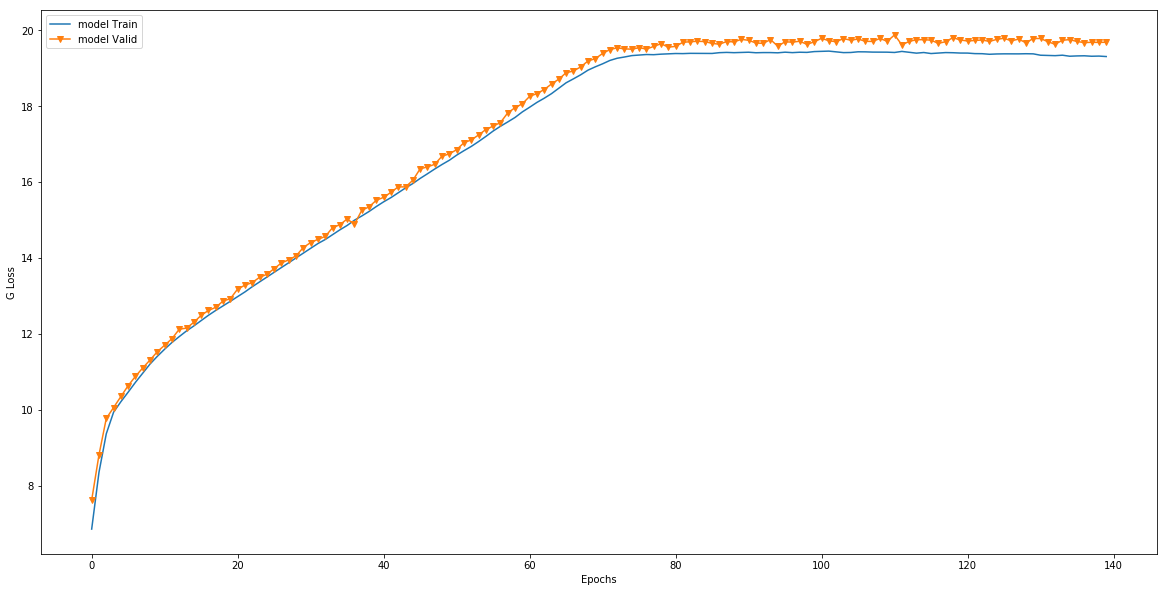

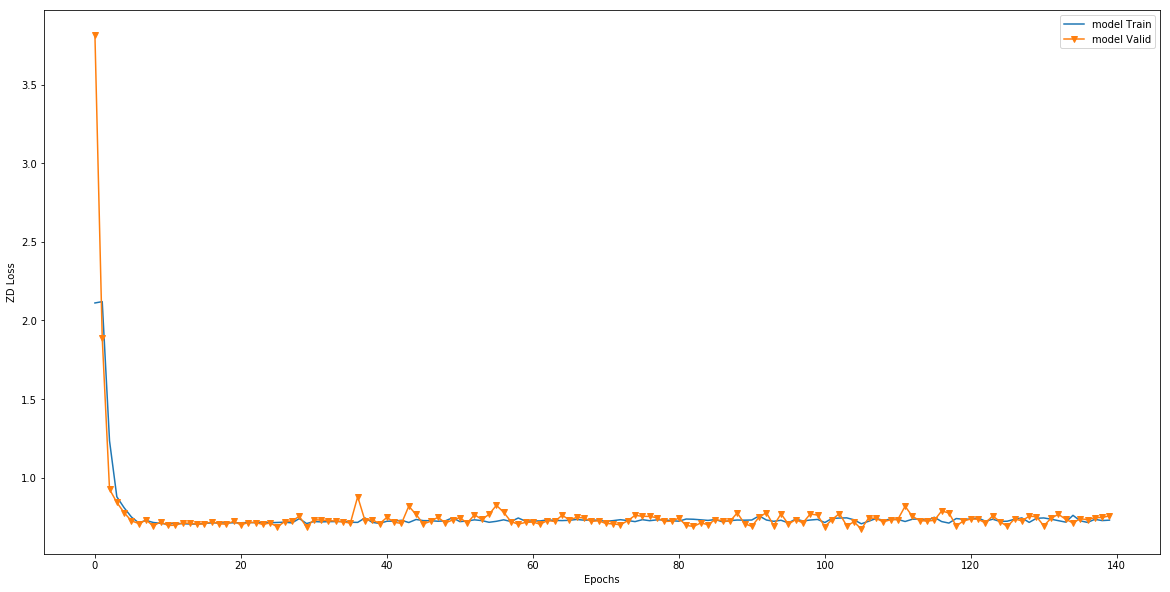

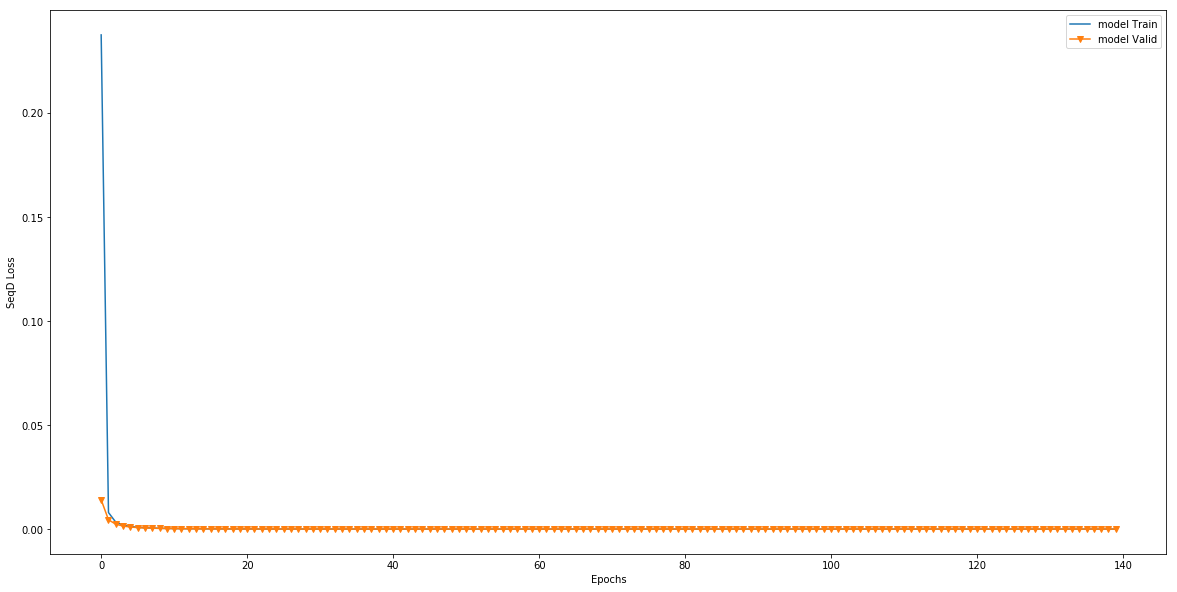

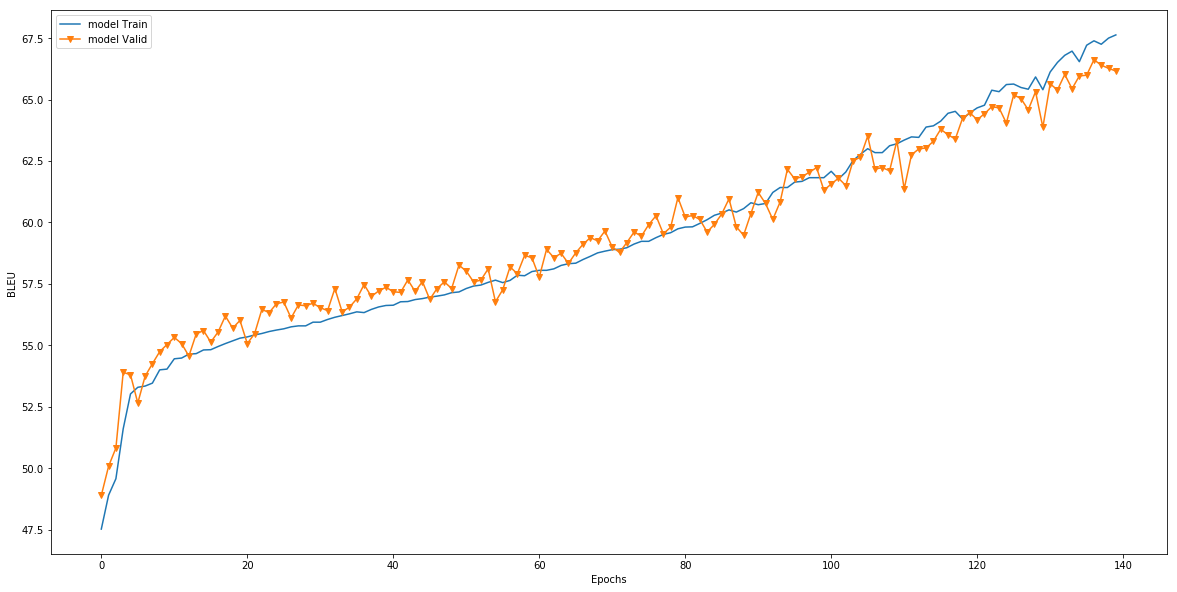

========== Start epoch 141 at 06:15:18 ==========
Epoch 141 Train: BLEU: 67.98, AE: 0.93909, G: 19.30220, ZD: 0.71988, SeqD: 0.00000  at 06:19:43
Epoch 141 Valid: BLEU: 67.06, AE: 1.35043, G: 19.67546, ZD: 0.72291, SeqD: 0.00000  at 06:19:50

Origin:
	with three spokes stickin ' out of my pant leg
	fuck a headache , give me a migraine <eos>

Decoded: with all his own ' out of this
	that 's your gangstas and my friends i 'm a solve
	

Random sample:

Decoded w. style E:
	i got ta get my throat , get off
	but i 'm your daughter , i 'm not your jail <eos>

Decoded w. style M:
	i got some shit with that joint for the world
	i 'm a never never been afraid to shock <eos>

========== Start epoch 142 at 06:19:50 ==========
Epoch 142 Train: BLEU: 67.65, AE: 0.95162, G: 19.28954, ZD: 0.74247, SeqD: 0.00000  at 06:24:14
Epoch 142 Valid: BLEU: 66.59, AE: 1.38210, G: 19.72134, ZD: 0.73661, SeqD: 0.00000  at 06:24:22

Origin:
	a man and a woman are talking in a park <eos>

Decoded: a man and a woman

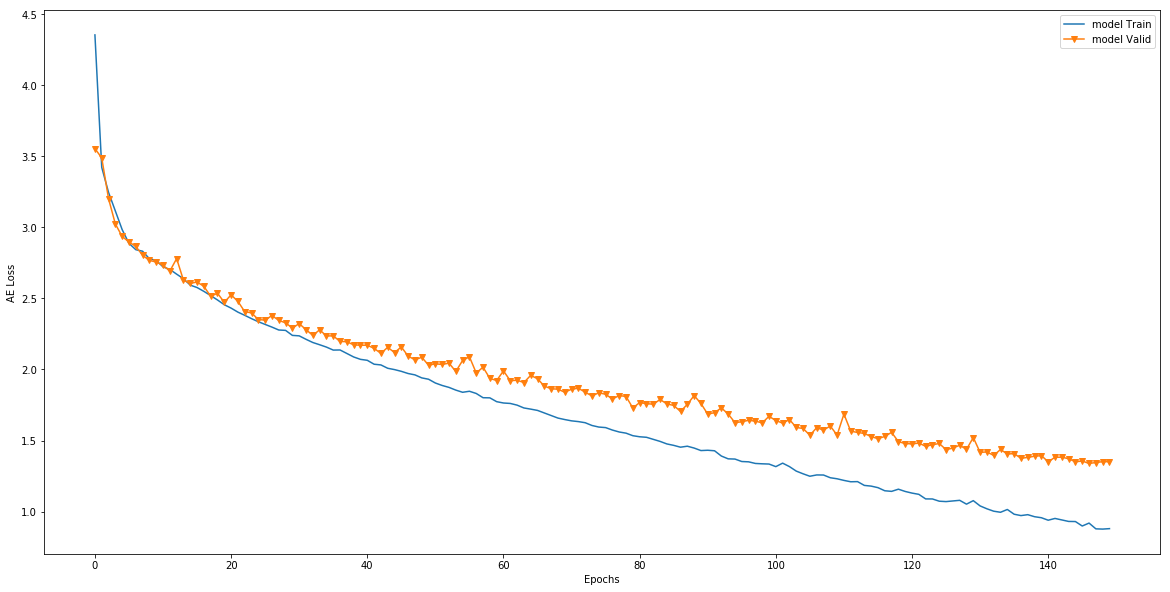

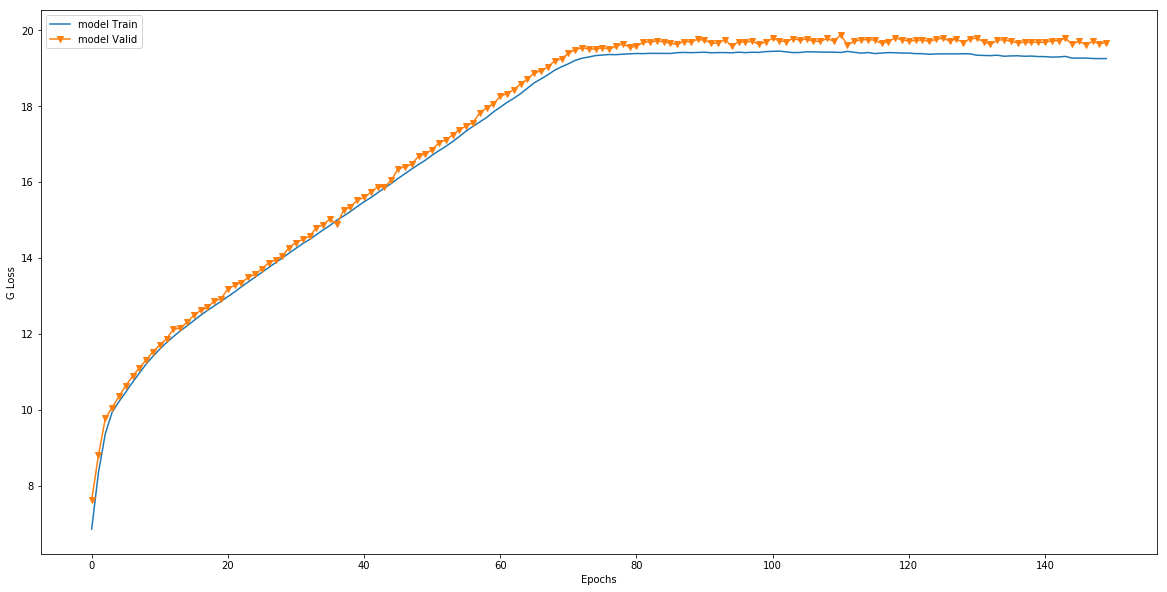

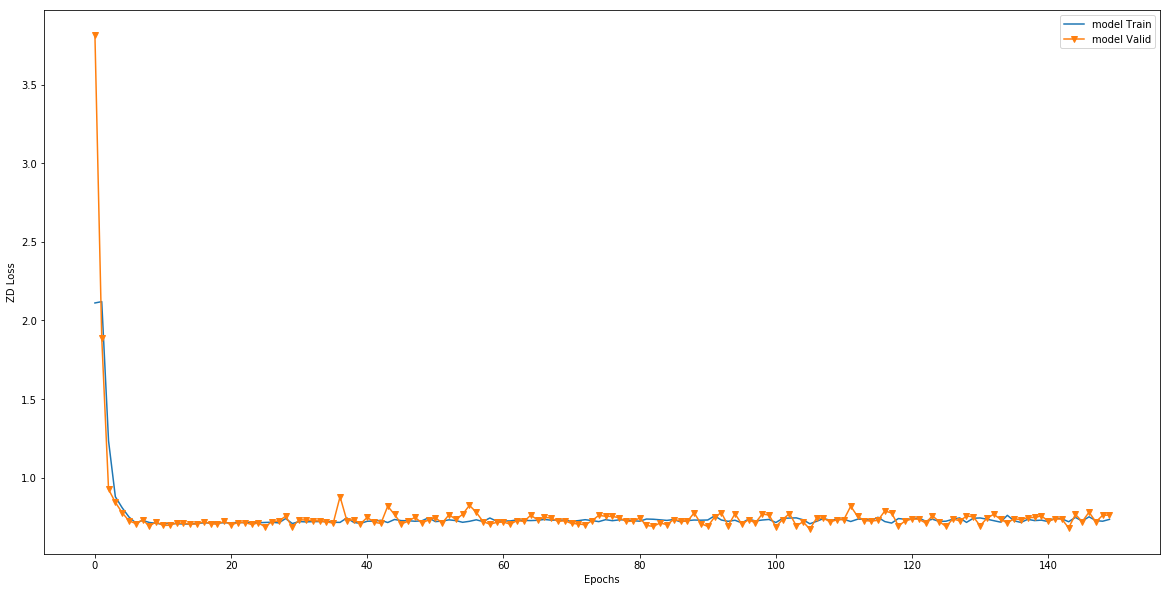

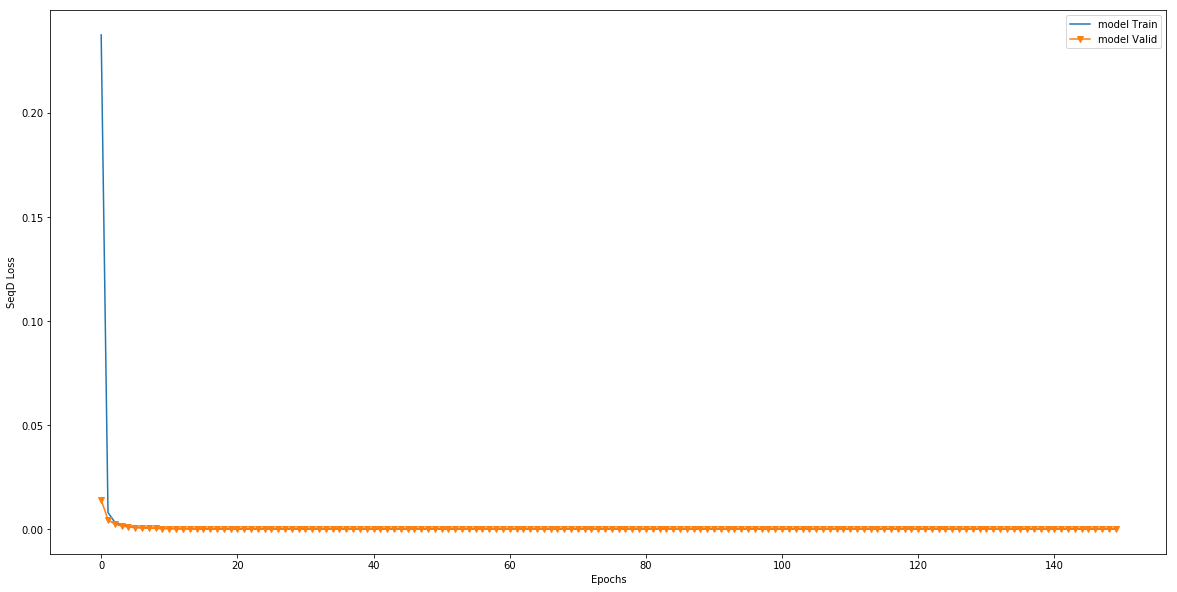

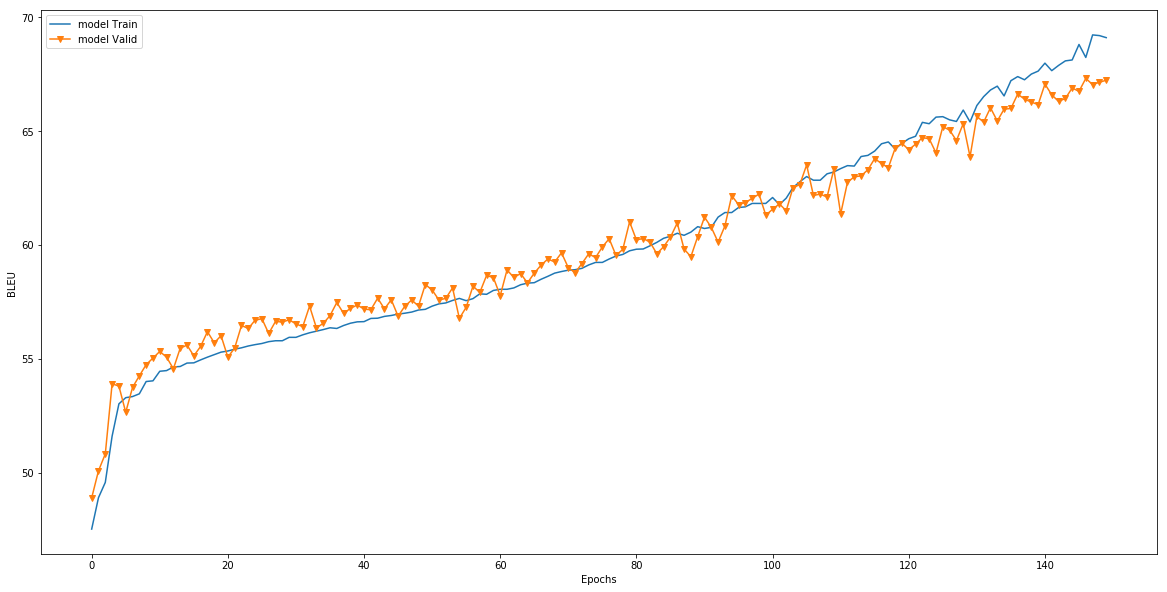

CPU times: user 9h 28min 56s, sys: 1h 22min 1s, total: 10h 50min 58s
Wall time: 11h 21min 12s


In [38]:
%%time

for epoch in range(1, 151):
    print("========== Start epoch {} at {} ==========".format(epoch, datetime.now().strftime("%H:%M:%S")))
    trn, val, _ = metrics['model']
    trn.append(train_raae(epoch, Enc, Dec, ZDisc, SeqDisc, prior_size, train_dl))
    val.append(validate_raae(epoch, Enc, Dec, ZDisc, SeqDisc, prior_size, valid_dl, 'Valid'))
    print_decoded(Enc, Dec, gen_dl)
    print_sample(Dec, sample_size=prior_size, max_seq_len=41)
            
    if epoch % 10 == 0: 
        torch.save(Enc.state_dict(), f'LSTM-T2D-2L-{hidden_size}H-3L.enc.e{epoch}.pt')
        torch.save(Dec.state_dict(), f'LSTM-T2D-2L-{hidden_size}H-3L.dec.e{epoch}.pt')
        torch.save(ZDisc.state_dict(), f'LSTM-T2D-2L-{hidden_size}H-3L.zdisc.e{epoch}.pt')
        torch.save(SeqDisc.state_dict(), f'LSTM-T2D-2L-{hidden_size}H-3L.seqdisc.e{epoch}.pt')
        plot_metrics(metrics, 0, 'AE Loss')
        plot_metrics(metrics, 1, 'G Loss')
        plot_metrics(metrics, 2, 'ZD Loss')
        plot_metrics(metrics, 3, 'SeqD Loss')
        plot_metrics(metrics, 4, 'BLEU')
        